#### Run the first box so that the notebook gets 100% of your window

Hopefully, you do not need to run the rest of the boxes, assuming that you see the box outputs.

Then, see the [Instructions](#Instructions) and scroll down to the [ViT-3B](#ViT-3B) and [GreedySoups](#GreedySoups) sections.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import base64
from enum import Enum
from io import BytesIO
import json
import os
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm

from src import datasets, utils
from src.evaluation import ErrorClsTypes, EvalManager

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

pd.set_option('display.max_colwidth', None)

%load_ext autoreload
%autoreload 2

2023-11-03 12:12:51.692441: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 12:12:51.721766: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 12:12:51.722238: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 12:12:52.175272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Helpers to visualize images in the dataframes

In [3]:
imagenet_val_root = datasets.get_dataset_root(dataset='imagenet', split="val")
# df['image'] = df['img_rel_path'].map(lambda f: load_image(f))

def load_image(path):
    if not path.startswith(imagenet_val_root):
        path = os.path.join(imagenet_val_root, path)
    i = Image.open(path)
    i.thumbnail((500, 500), Image.Resampling.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

def img_rel_path_formatter(img_rel_path):
    im = load_image(os.path.join(imagenet_val_root, img_rel_path))
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

def visualize_df(df_to_vis):
    print('Number of samples:', df_to_vis.shape[0])
    # print(df_to_vis.columns)
    show_columns = [
        'wnet_id', 'file_name', 'img_rel_path',
        'target', 'target_desc', 'multi_label', 'multi_desc', 'top1', 'top1_desc',
        'error_types', 'clip_top10_train_files', 'clip_top10_supercls',
        # 'DB_category', 'DB_severity'
    ]
    if 'DB_category' in df_to_vis.columns:
        assert 'DB_severity' in df_to_vis.columns
        show_columns += ['DB_category', 'DB_severity']
    return HTML(df_to_vis[show_columns].to_html(escape=False, formatters=dict(img_rel_path=img_rel_path_formatter)))

# Inspect DoughBagel errors

In [4]:
eval_manager = EvalManager(dataset='imagenet')

2023-11-03 12:13:00.910 | INFO     | src.evaluation:__init__:78 - Initialize EvalManager
2023-11-03 12:13:01.157 | INFO     | src.utils:add_multi_labels_to_df:114 - Load multilabels from imagenet2012_multilabel
2023-11-03 12:13:01.168851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 12:13:01.169034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 12:13:01.169323: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU l

2023-11-03 12:13:44.401 | DEBUG    | src.utils:common_co_occurrences:278 - Appearing more than once: 1019 pairs
2023-11-03 12:13:44.466 | INFO     | src.evaluation:__init__:175 - DONE: 2038 pairs in total. (a,b) and (b,a) both counted
2023-11-03 12:13:44.467 | INFO     | src.evaluation:__init__:178 - === DoughBagel non-prototypical samples: 36 in total ===


In [5]:
mistakes_file_name = {
    'vit3b': 'vit3b_mistakes.json',
    'greedysoups': 'greedy_soups_mistakes.json'
}

our_mistake_types = [
    ErrorClsTypes.same_superclass,
    ErrorClsTypes.OOV_detected_by_clip,
    ErrorClsTypes.non_prototypical,
    ErrorClsTypes.common_co_occurrences,
    ErrorClsTypes.not_classified
]
our_mistake_types_text = [
    'same supercls (fine-gr)',
    'fine-gr OOV (CLIP)',
    'non-proto',
    'common co occ (spur corr)',
    'uncls'
]

def print_cnt(cnt, dough_bagel_mistake_types):
    num_mistakes = sum(sum(row) for row in cnt)
    print('Number of mistakes:', num_mistakes)
    print(f'{"DoughBagel":>36}' + ' '.join(f'{t:>24}' for t in our_mistake_types_text + ['Total (row)']))
    for i, row in enumerate(cnt):
        print(f'{dough_bagel_mistake_types[i]:>36}' + ' '.join(f'{t:>24}' for t in row + [sum(row)]))
    col_sums = [sum(cnt[i][j] for i in range(len(dough_bagel_mistake_types))) for j in range(len(our_mistake_types))]
    print(f'{"Total (col)":>36}' + ' '.join(f'{t:>24}' for t in col_sums + [num_mistakes]))


def error_classifications_match(row) -> bool:
    if row.DB_category in ['Fine-grained error', 'Fine-grained with Multilabel Options']:
        return ErrorClsTypes.same_superclass in row.error_types
    elif row.DB_category in ['Fine-grained error with OOV', 'Fine-grained with OOV']:
        return ErrorClsTypes.OOV_detected_by_clip in row.error_types
    elif row.DB_category == 'Non-prototypical':
        return ErrorClsTypes.non_prototypical in row.error_types
    elif row.DB_category == 'Spurious Correlation':
        return ErrorClsTypes.common_co_occurrences in row.error_types
    else:
        raise ValueError(f'Unconsidered DoughBagel error category: {row.DB_category}')


def filter_by_matching_dough_bagel(df_mistakes: pd.DataFrame, match_dough_bagel: bool) -> pd.DataFrame:
    return df_mistakes[df_mistakes.apply(
        lambda row: error_classifications_match(row) == match_dough_bagel,
        axis=1
    )]


def filter_by_severity(df_mistakes: pd.DataFrame, severity: str) -> pd.DataFrame:
    assert severity in ['all', 'major', 'minor']
    if severity == 'all':
        return df_mistakes
    elif severity == 'major':
        return df_mistakes[df_mistakes['DB_severity'] == 'Major']
    else:
        assert severity == 'minor'
        return df_mistakes[df_mistakes['DB_severity'] != 'Major']


def filter_mistakes(
        df_mistakes: pd.DataFrame,
        classified_by_us: bool = True,
        match_dough_bagel: bool = False,
        severity: str = 'all'
) -> pd.DataFrame:
    # classified_by_us == False AND match_dough_bagel == True is invalid combination
    assert classified_by_us or not match_dough_bagel
    
    # DoughBagel have 3 severity levels: Minor + Borderline (both considered minor), and Major
    assert severity in ['all', 'major', 'minor']
    
    df = df_mistakes
    if classified_by_us:
        df = df[~ErrorClsTypes.filter_error_type(df_mistakes, ErrorClsTypes.not_classified)]
    else:
        # i.e., consider only those that are *not* classified by us
        df = df[ErrorClsTypes.filter_error_type(df_mistakes, ErrorClsTypes.not_classified)]
    
    df = filter_by_matching_dough_bagel(df, match_dough_bagel)
    df = filter_by_severity(df, severity)
    
    return df


def get_mistakes_df(model_name: str) -> pd.DataFrame:
    imagenet_mistakes_metadata_path = utils.get_root_path() / 'imagenet-mistakes' / 'metadata'
    with open(imagenet_mistakes_metadata_path / mistakes_file_name[model_name], 'r') as json_file:
        dough_bagel_mistakes = json.load(json_file)
#     print(dough_bagel_mistakes)
    
    dough_bagel_mistake_types = sorted(set(
        m['failure category'] for _, m in dough_bagel_mistakes.items()
    ))
    print(dough_bagel_mistake_types)

    df = eval_manager.prepare_and_eval_model(model_name)
    
    df = df[~df['is_problematic']]
    df = df[~ErrorClsTypes.filter_error_type(df, ErrorClsTypes.correct)]

    df_non_mistakes = df[df['file_name'].map(lambda file_name: file_name not in dough_bagel_mistakes)]
    assert (
        ErrorClsTypes.filter_error_type(df_non_mistakes, ErrorClsTypes.correct_collapsed_mapping) | \
        ErrorClsTypes.filter_error_type(df_non_mistakes, ErrorClsTypes.correct_multi_label)
    ).all()

    df_mistakes = df[df['file_name'].isin(dough_bagel_mistakes)]
    assert df_mistakes.shape[0] == len(dough_bagel_mistakes)
    
    cnt_combined = [[0] * len(our_mistake_types) for _ in range(len(dough_bagel_mistake_types))]
    cnt_major = [[0] * len(our_mistake_types) for _ in range(len(dough_bagel_mistake_types))]
    cnt_minor = [[0] * len(our_mistake_types) for _ in range(len(dough_bagel_mistake_types))]
    
    for _, row in df_mistakes.iterrows():
        file_name = row.file_name
        assert dough_bagel_mistakes[file_name]['top_prediction'] == row.top1
        
        failure_category = dough_bagel_mistakes[file_name]['failure category']
        failure_severity = dough_bagel_mistakes[file_name]['failure severity']
        
        row_idx = dough_bagel_mistake_types.index(failure_category)
        col_idx = -1
        for i, our_mistake_type in enumerate(our_mistake_types):
            if our_mistake_type in row.error_types:
                assert col_idx == -1
                col_idx = i
        
        cnt_combined[row_idx][col_idx] += 1
        if failure_severity == 'Major':
            cnt_major[row_idx][col_idx] += 1
        else:
            cnt_minor[row_idx][col_idx] += 1

    print('Model name:', model_name)
    print('All errors (Major + Minor) counts:')
    print_cnt(cnt_combined, dough_bagel_mistake_types)
    print()
    print('Minor errors counts:')
    print_cnt(cnt_minor, dough_bagel_mistake_types)
    print()
    print('Major errors counts:')
    print_cnt(cnt_major, dough_bagel_mistake_types)
    
    df_mistakes['DB_category'] = df_mistakes['file_name'].map(
        lambda file_name: dough_bagel_mistakes[file_name]['failure category']
    )
    df_mistakes['DB_severity'] = df_mistakes['file_name'].map(
        lambda file_name: dough_bagel_mistakes[file_name]['failure severity']
    )
    
    num_unclassified_all = ErrorClsTypes.filter_error_type(df_mistakes, ErrorClsTypes.not_classified).sum()
    
    for severity in ['all', 'minor', 'major']:
        df_mistakes_severity = filter_by_severity(df_mistakes, severity)
        
        df_classified_matching = filter_mistakes(df_mistakes_severity, classified_by_us=True, match_dough_bagel=True, severity=severity)
        df_classified_not_matching = filter_mistakes(df_mistakes_severity, classified_by_us=True, match_dough_bagel=False, severity=severity)
        df_unclassified = filter_mistakes(df_mistakes_severity, classified_by_us=False, match_dough_bagel=False, severity=severity)
        
        num_classified = df_classified_matching.shape[0] + df_classified_not_matching.shape[0]
        assert df_mistakes_severity.shape[0] == num_classified + df_unclassified.shape[0]
        
        print(f'Severity = {severity}, total: {df_mistakes_severity.shape[0]}')
        print('classified + matching DoughBagel: {} ({:.2f}% of all with that severity, {:.2f}% of the classified with that severity)'.format(
            df_classified_matching.shape[0],
            100 * df_classified_matching.shape[0] / df_mistakes_severity.shape[0],
            100 * df_classified_matching.shape[0] / num_classified
        ))
        print('classified + not matching DoughBagel: {} ({:.2f}% of all with that severity, {:.2f}% of the classified with that severity)'.format(
            df_classified_not_matching.shape[0],
            100 * df_classified_not_matching.shape[0] / df_mistakes_severity.shape[0],
            100 * df_classified_not_matching.shape[0] / num_classified
        ))
        print('unclassified (thus not matching DoughBagel): {} ({:.2f}% of all with that severity, {:.2f}% of all unclassified)'.format(
            df_unclassified.shape[0],
            100 * df_unclassified.shape[0] / df_mistakes_severity.shape[0],
            100 * df_unclassified.shape[0] / num_unclassified_all
        ))
        print()
    
    return df_mistakes

# Instructions

The first cell of each of the ViT-3B and GreedySoups sections present summary statistics (similar to Table 1 in the paper) for the two models.\
The second cell in each section shows the mistakes that the models make and which we classify, but our automated error classification does not match DoughBagel's manual categorization.

Description of the output DataFrame columns:
* `wnet_id` - WordNet class of the sample.
* `file_name` - file name of the sample image.
* `img_rel_path` = `wnet_id/file_name` and can be found in the `val` ImageNet folder. In this notebook we show the image directly.
* `target` - the ground-truth ImageNet (numerical) class id.
* `target_desc` - description of the ImageNet ground truth.
* `multi_label` - multi labels from Shankar's [ImageNet-multilabel](https://www.tensorflow.org/datasets/catalog/imagenet2012_multilabel) dataset.
* `multi_desc` - descriptions of each of the corresponding multi-labels. Each `(...)` in the list presents the description of a single label from the multi-label list.
* `top1` - the top-1 model prediction.
* `top1_desc` - description of the top-1 model prediction.
* `error_types` - the output of _our_ error classification pipeline with a short explanation. E.g., for fine-grained errors we also list the common superclasses, for fine-grained OOV - the top-5 proposals and their CLIP probabilities, for spurious correlations - the classes which commonly co-occur with the model's top-1 prediction.
* `clip_top10_train_files` - the images from the _training_ set that are the most similar to the evaluated sample, according to CLIP's embeddings.
* `clip_top10_supercls` - superclases of the ground-truth targets of the training images in the `clip_top10_train_files` list.
* `DB_category` - DoughBagel's manual error categorization.
* `DB_severity` - severity of the mistake, according to DoughBagel.

Tips & hints:
- You can enlarge the sample images (and make them smaller again) by double-clicking on them.
- You can automatically show single images and visualize ImageNet classes using the `src/show_images.ipynb` notebook. For it to work, you need to have the ImageNet dataset downloaded and the environment variables set up correctly following the instructions in the `README`.
- You can find our superclasses (together with WordNet ids and descriptions for each individual class) in the `artefacts/superclasses.txt` file.

For each sample, the question we answer is:\
`Do you find our error classification equally (or more) good, informative and descriptive, compared to DoughBagel's manual categorization?`

# ViT-3B

In [6]:
vit3b_mistakes_df = get_mistakes_df('vit3b')
vit3b_classified_not_matching = filter_mistakes(vit3b_mistakes_df, classified_by_us=True, match_dough_bagel=False)
vit3b_unclassified = filter_mistakes(vit3b_mistakes_df, classified_by_us=False, match_dough_bagel=False)

['Fine-grained error', 'Fine-grained error with OOV', 'Fine-grained with Multilabel Options', 'Non-prototypical', 'Spurious Correlation']


/tmp/ipykernel_1728621/3207358387.py:146: SettingWithCopyWarning:                                                                                     
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mistakes['DB_category'] = df_mistakes['file_name'].map(
/tmp/ipykernel_1728621/3207358387.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mistakes['DB_severity'] = df_mistakes['file_name'].map(


Model name: vit3b
All errors (Major + Minor) counts:
Number of mistakes: 378
                          DoughBagel same supercls (fine-gr)       fine-gr OOV (CLIP)                non-proto common co occ (spur corr)                    uncls              Total (row)
                  Fine-grained error                     191                       15                        0                       10                       25                      241
         Fine-grained error with OOV                       9                       20                        0                       11                       14                       54
Fine-grained with Multilabel Options                       1                        0                        0                        0                        0                        1
                    Non-prototypical                      13                        2                       12                        3                        0                  

### Classified by us but not matching DoughBagel categorization

Number of samples: 85



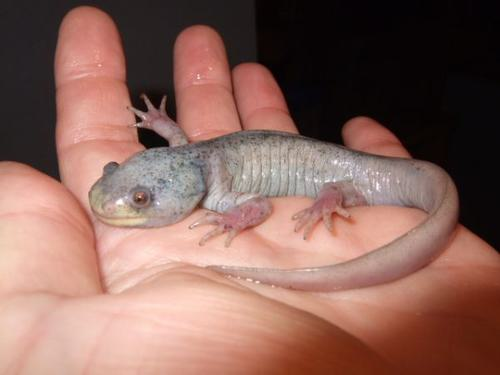
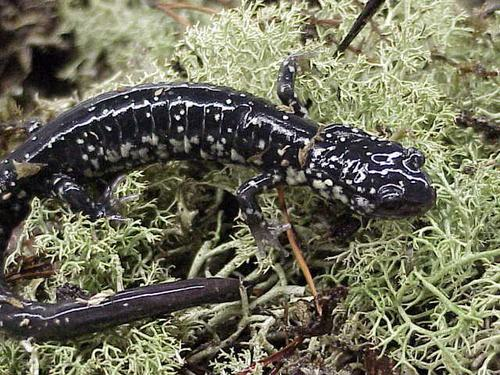
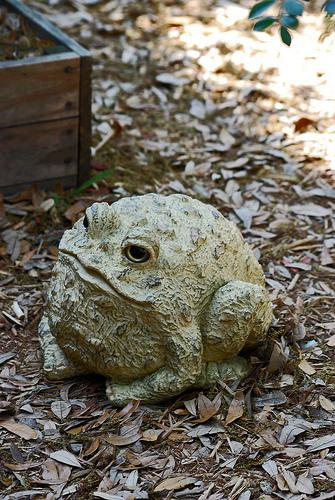
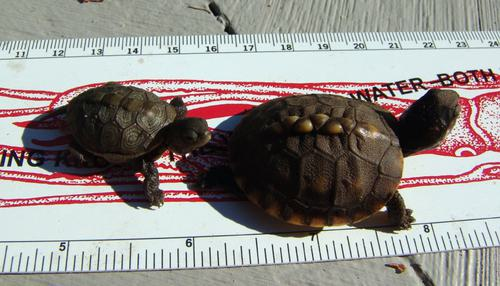
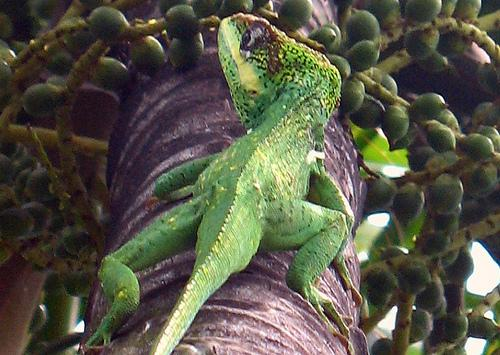
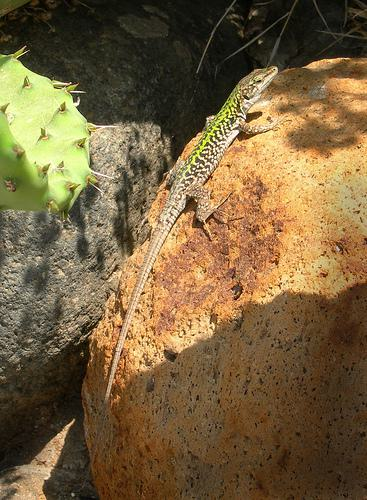
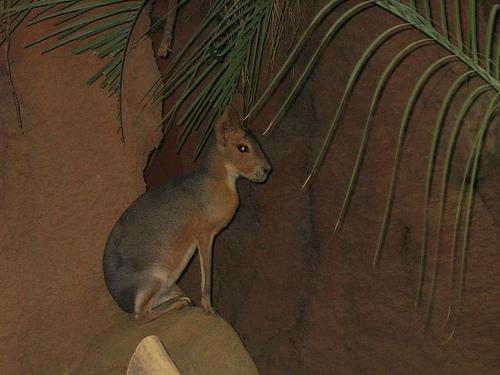
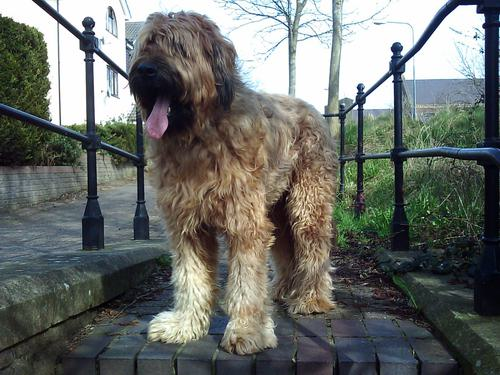
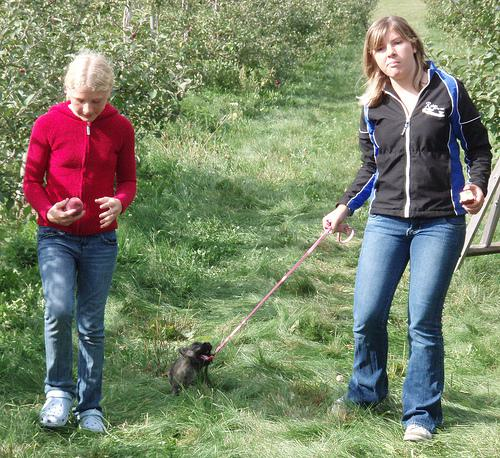
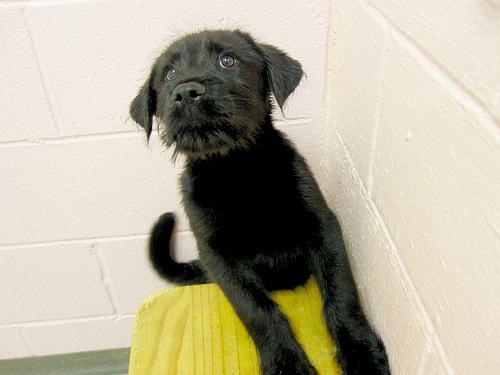
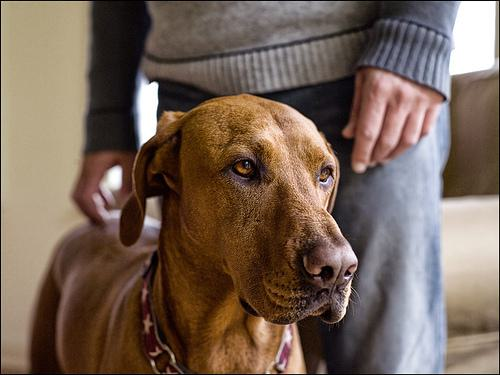
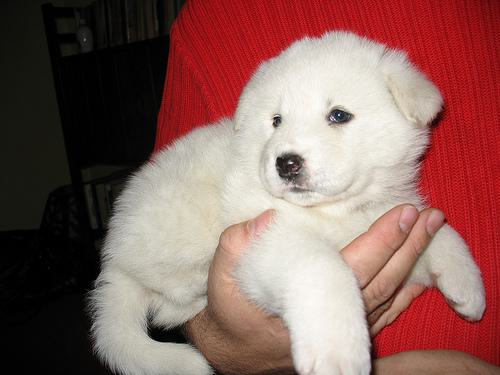
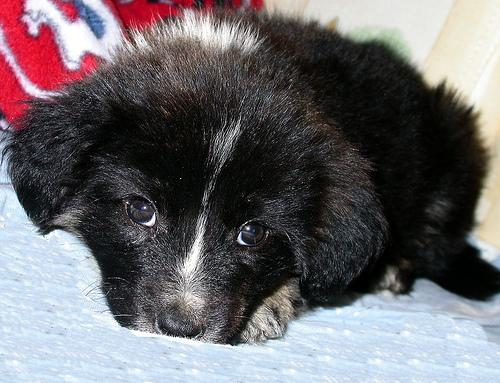
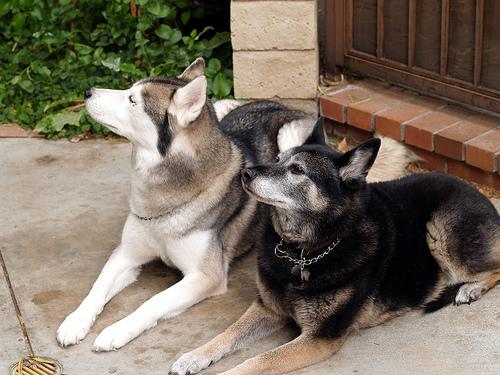
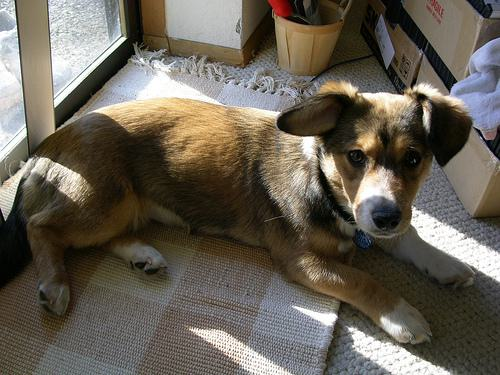
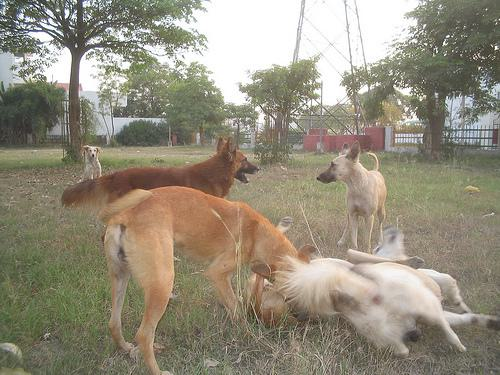
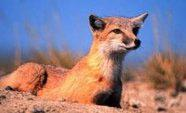
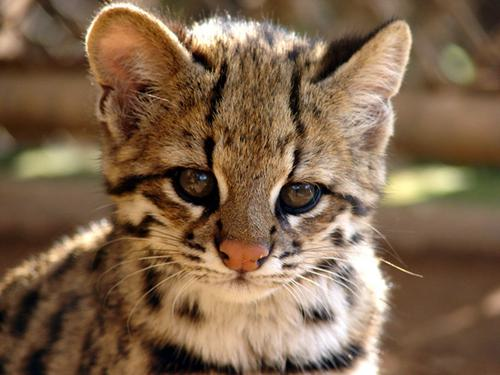
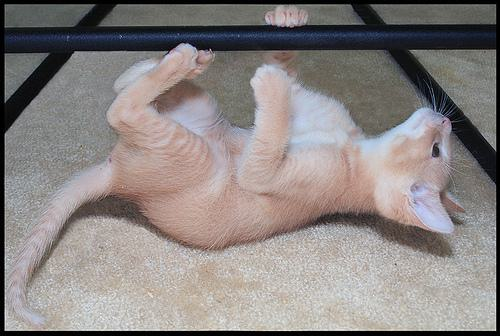
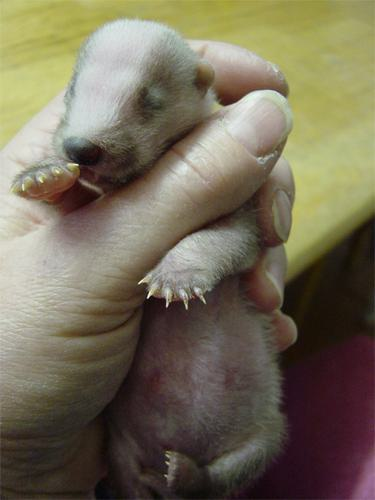
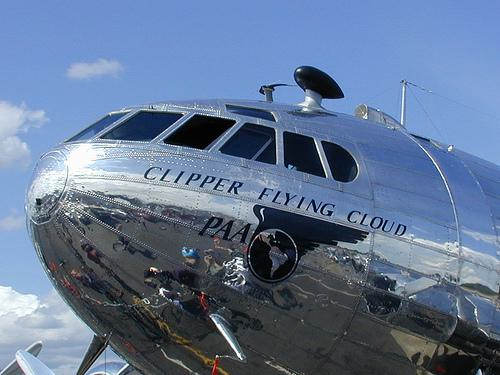
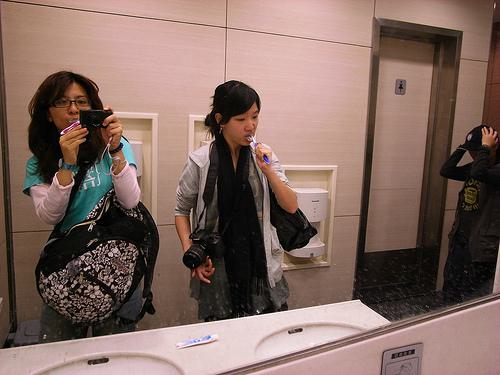
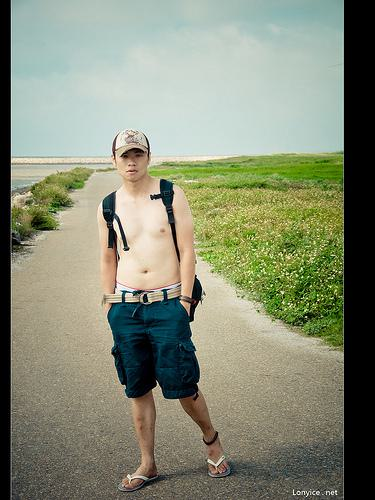
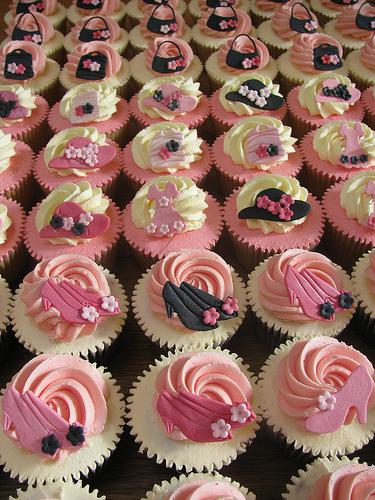
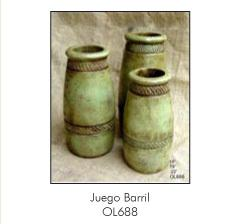
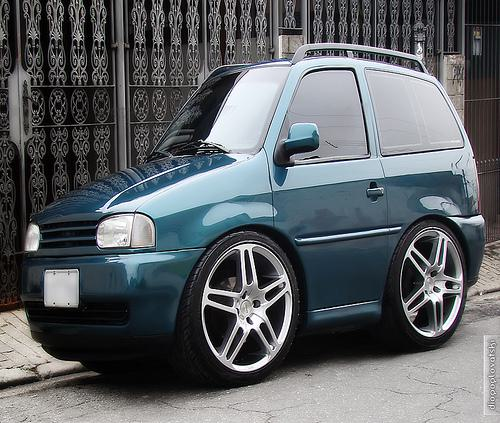
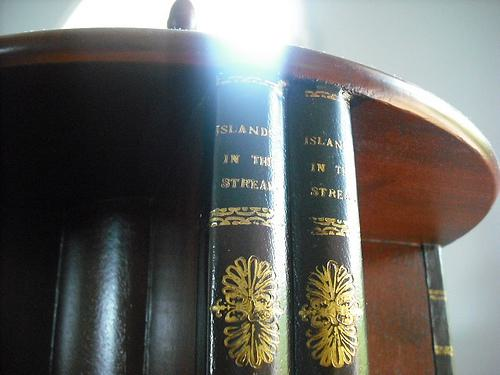
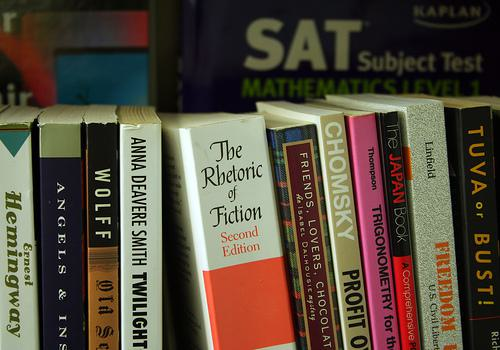
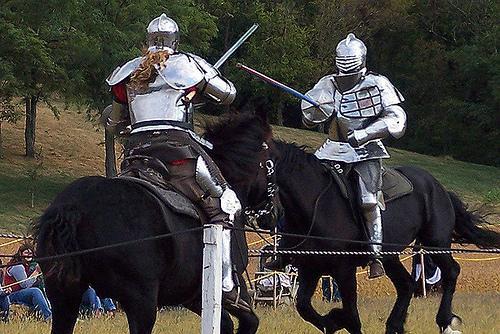
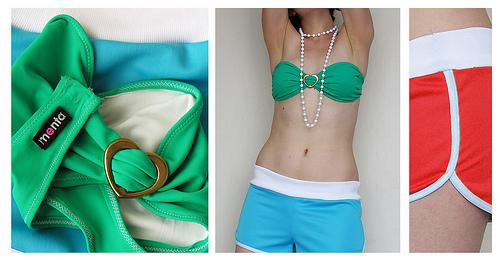
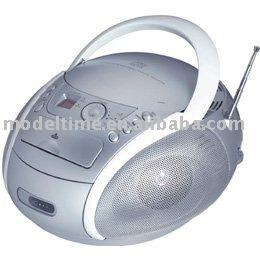
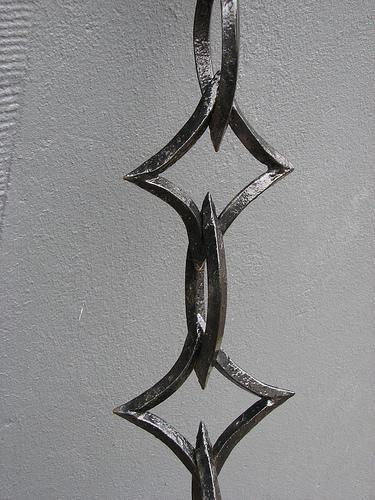
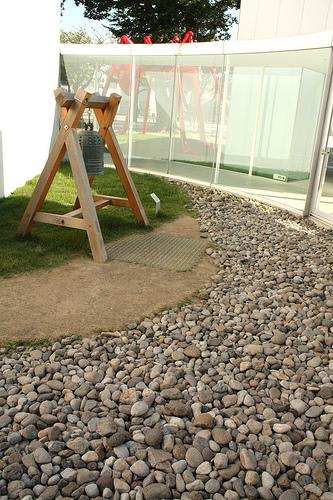
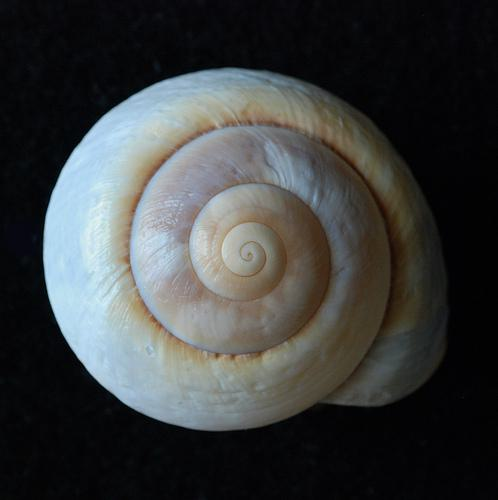
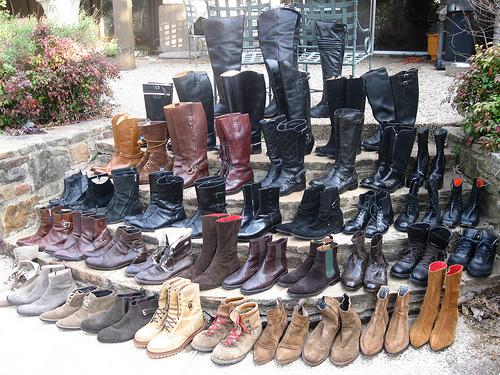
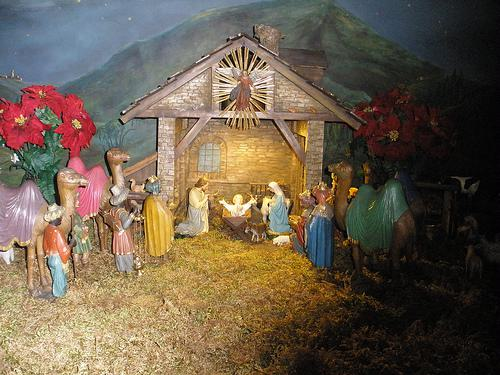
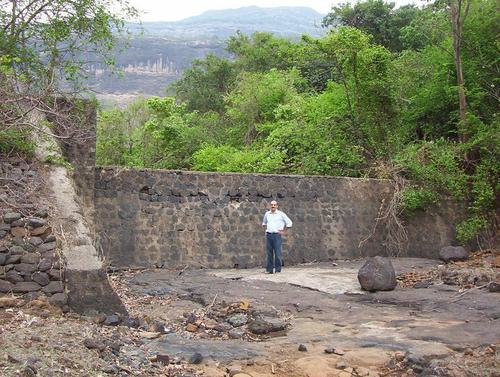
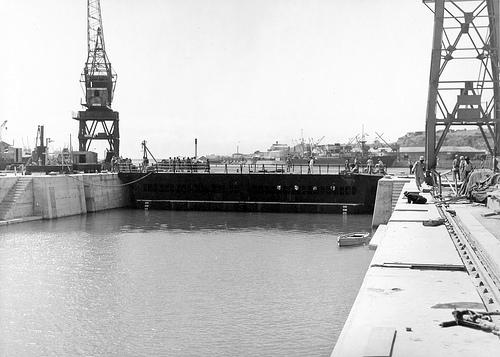
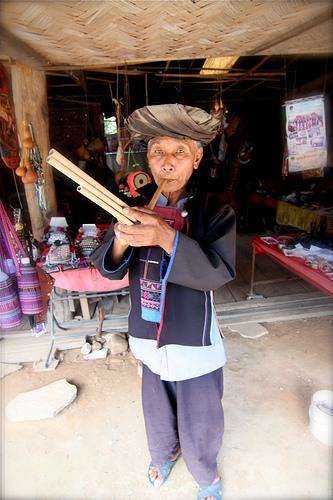
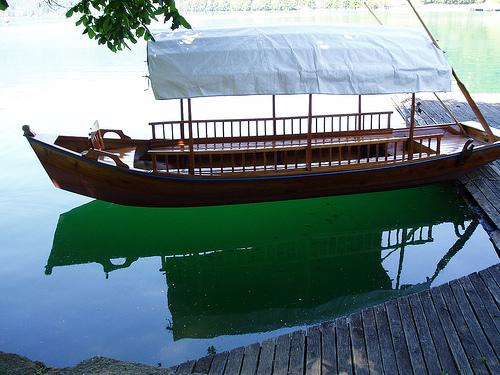
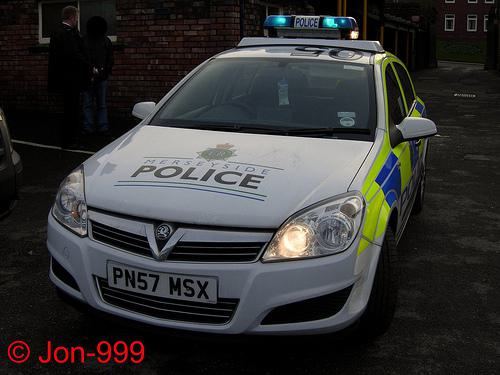
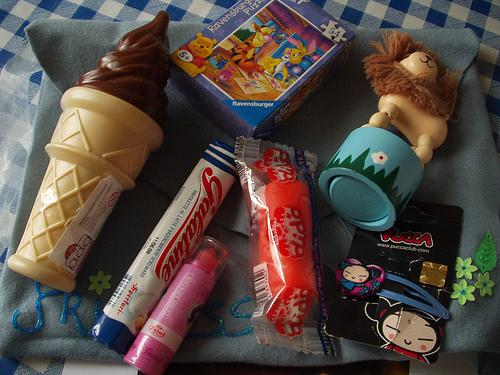
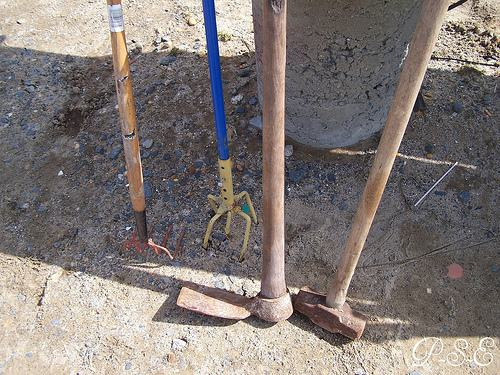
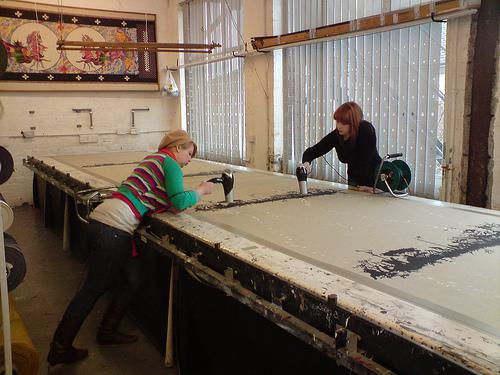
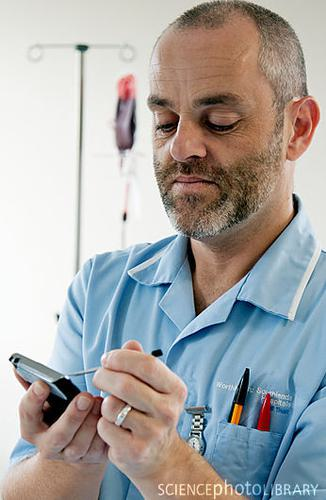
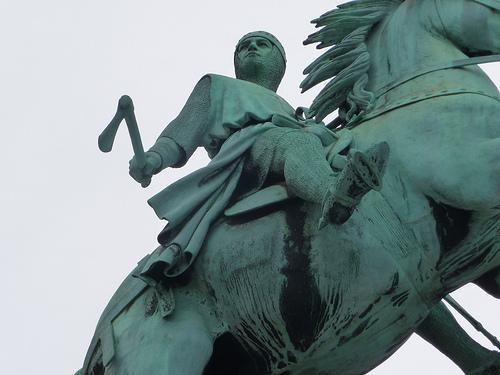
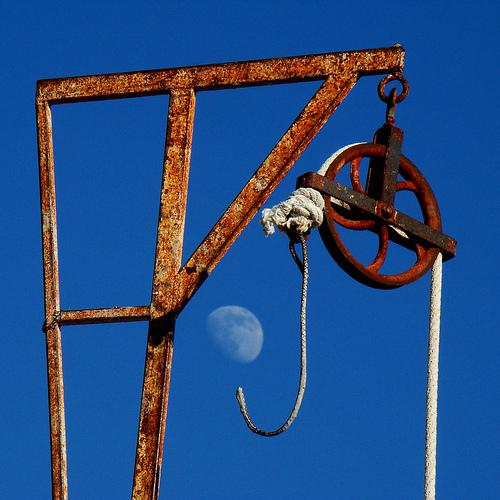
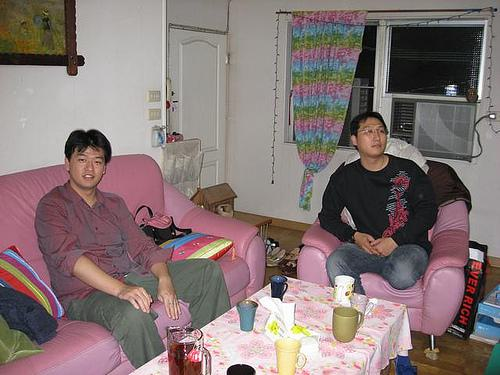
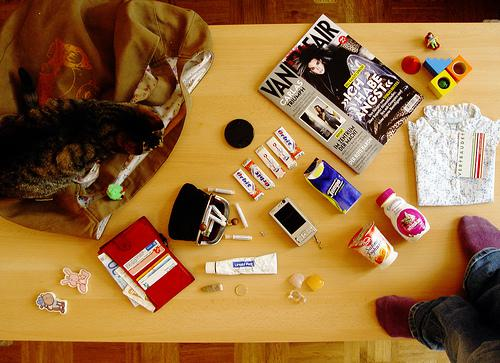
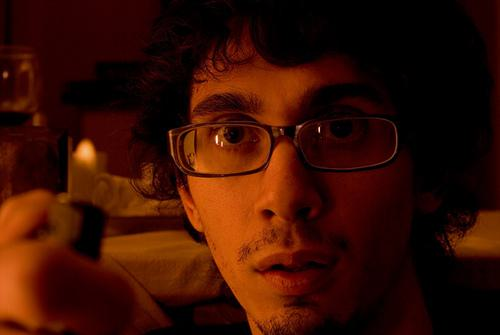
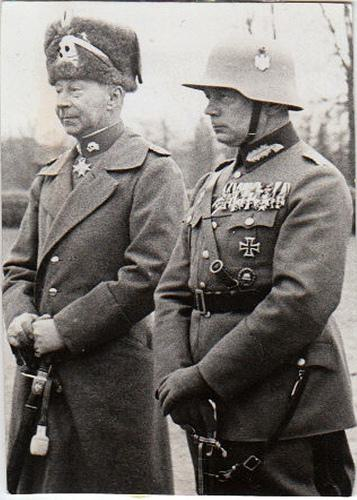
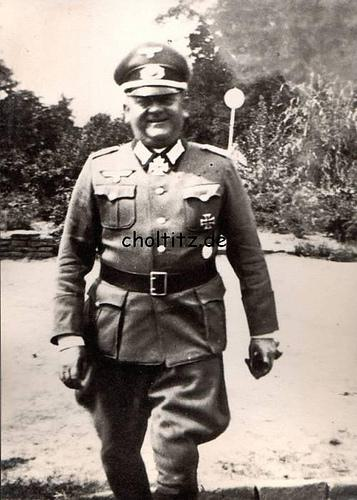
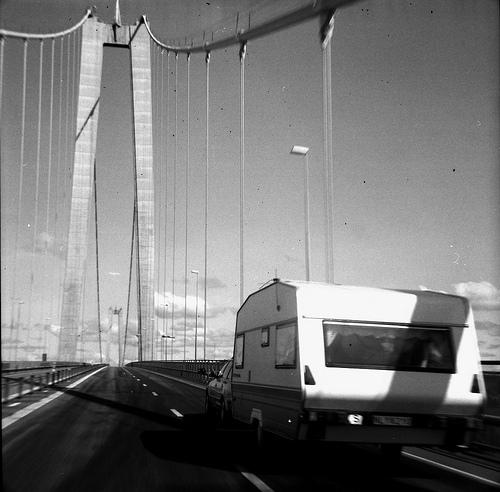
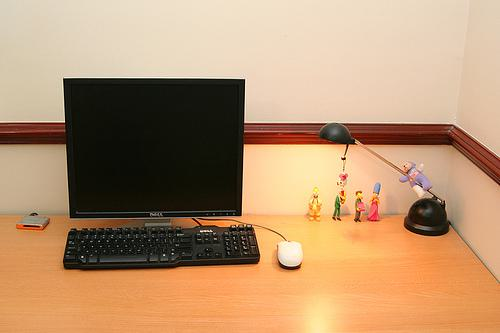
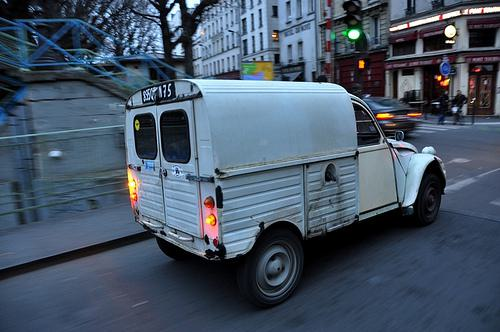
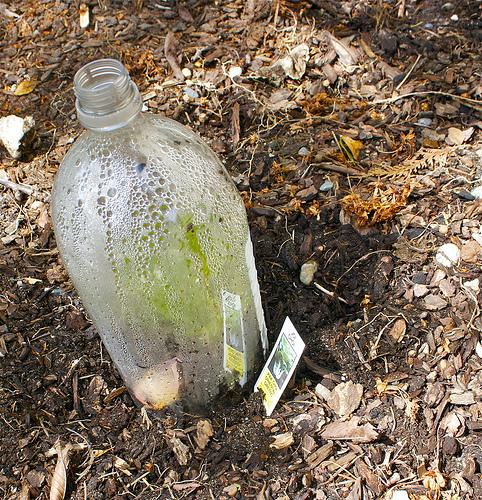
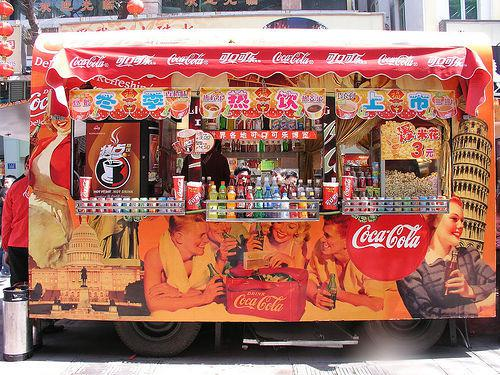
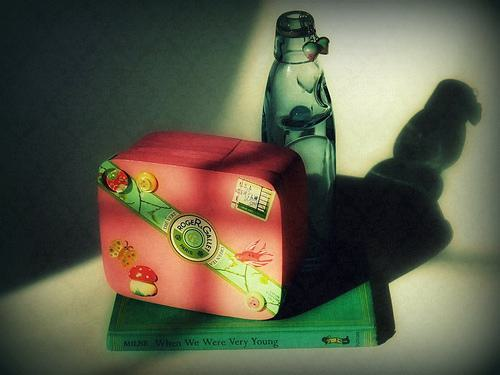
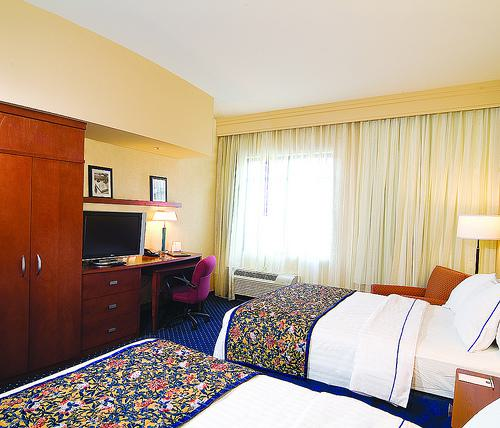
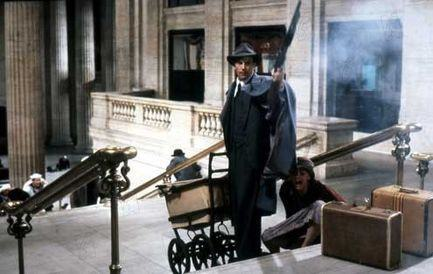
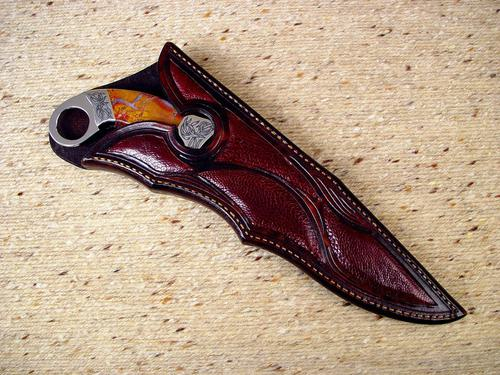
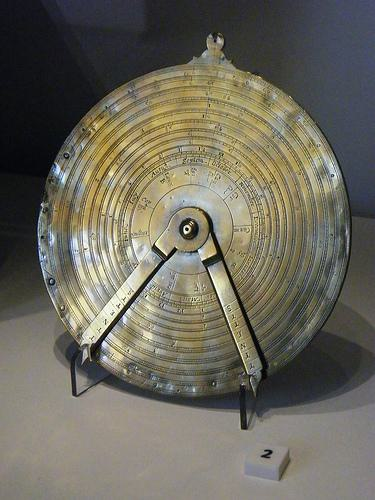
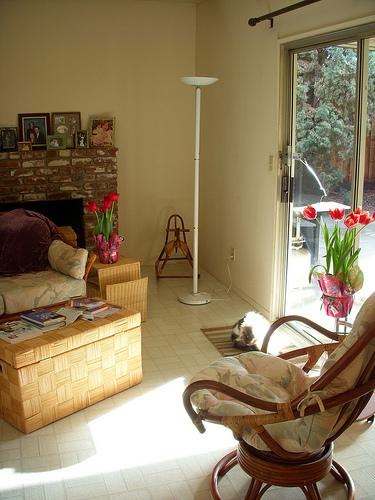
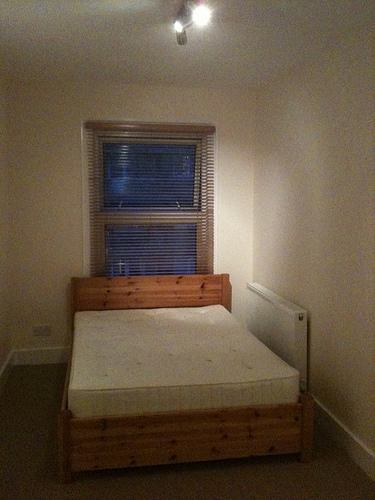
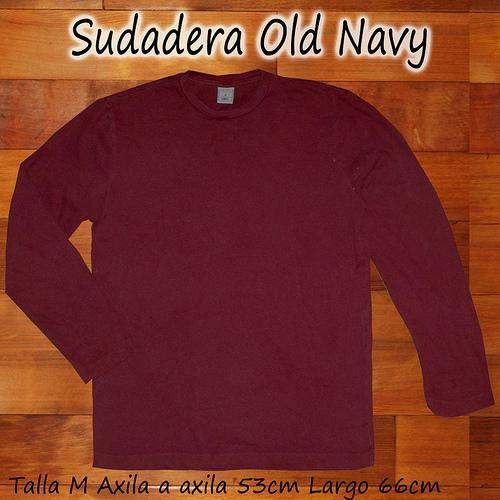
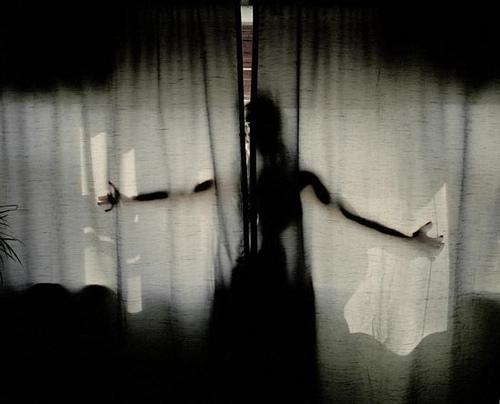
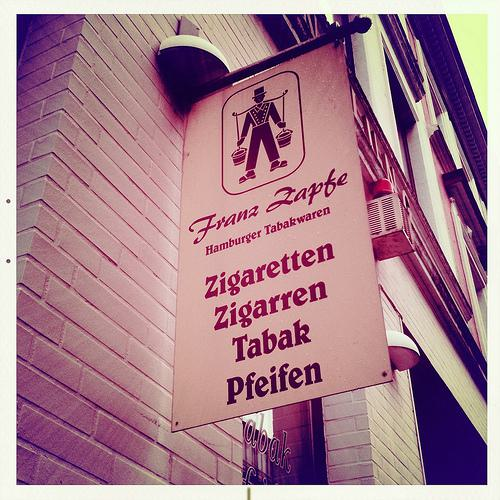
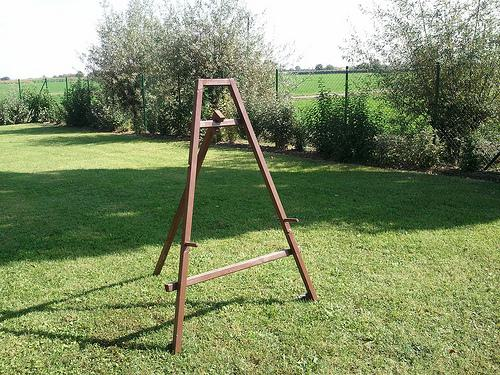
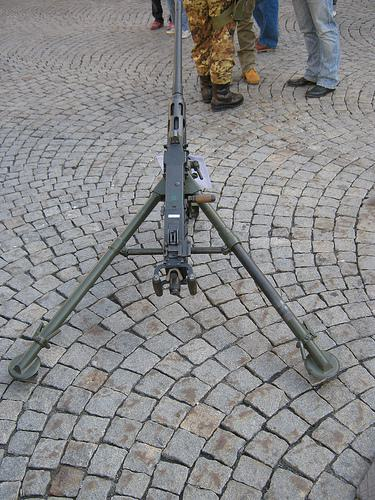
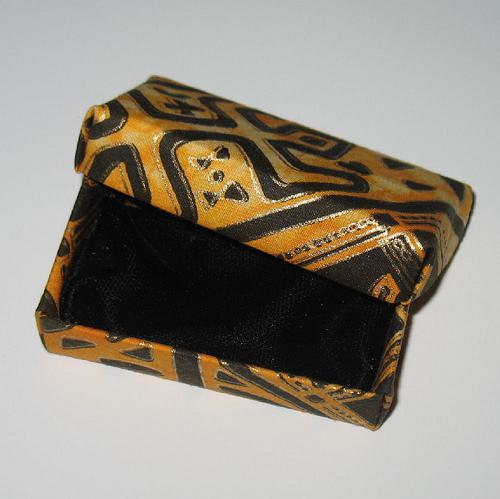
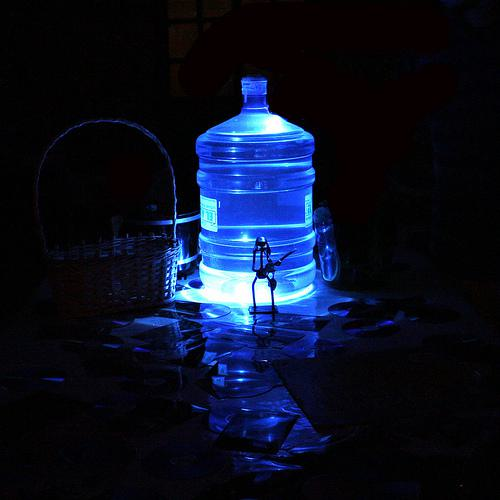
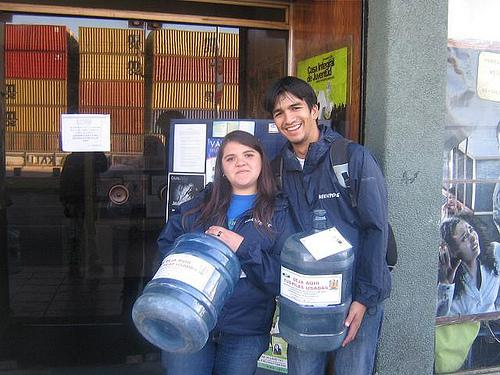
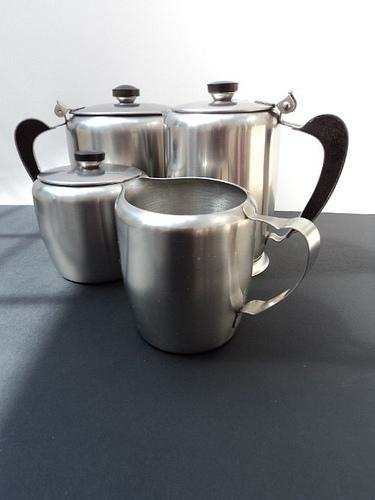
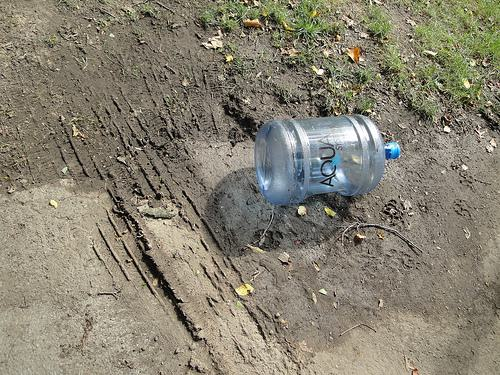
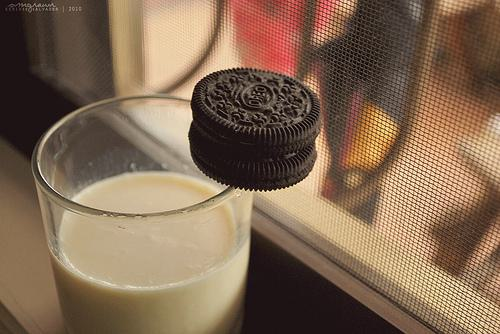
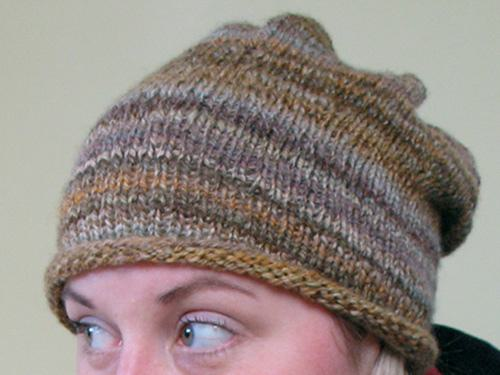
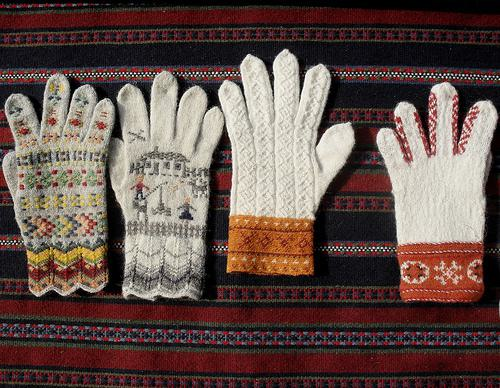
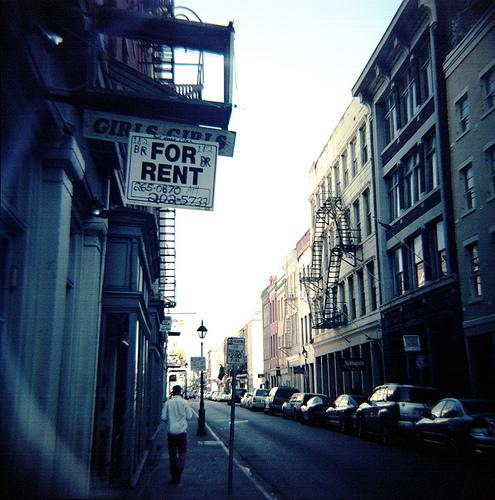
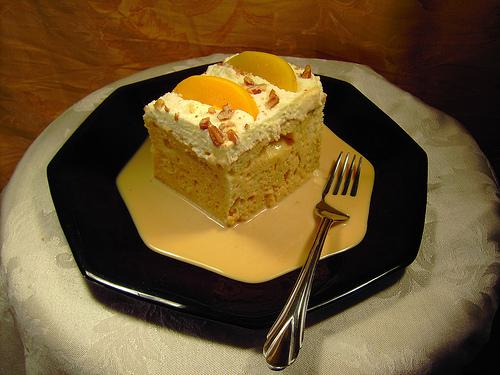
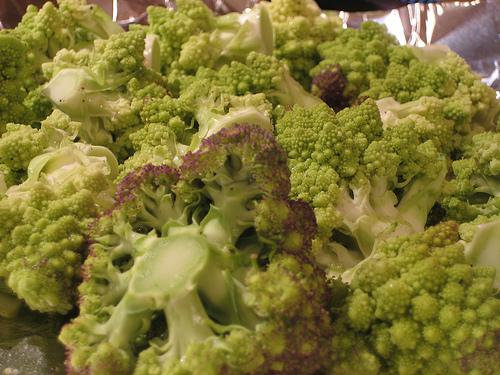
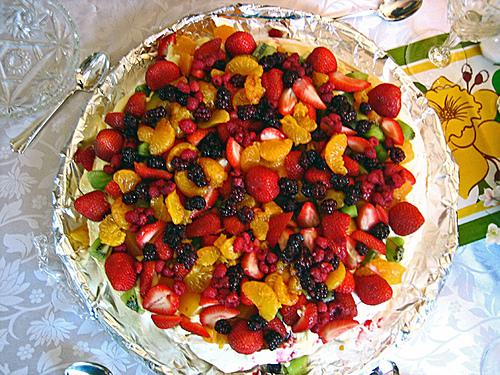
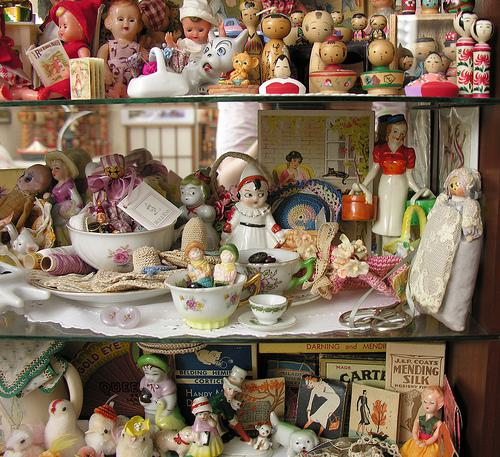
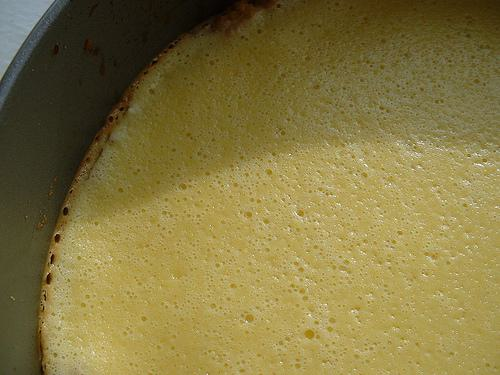
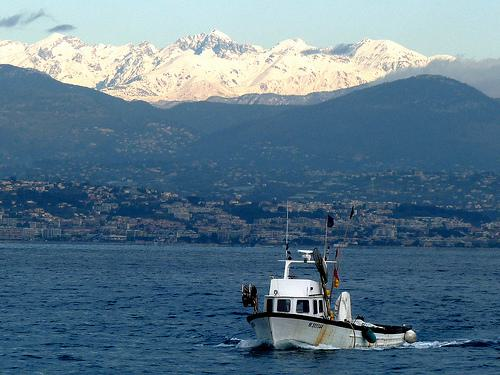
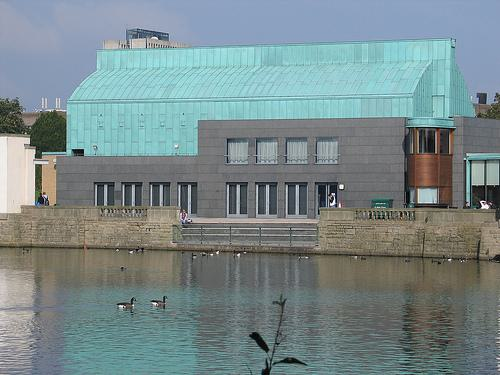

In [7]:
visualize_df(vit3b_classified_not_matching)

# GreedySoups

In [8]:
greedysoups_mistakes_df = get_mistakes_df('greedysoups')
greedysoups_classified_not_matching = filter_mistakes(greedysoups_mistakes_df, classified_by_us=True, match_dough_bagel=False)
greedysoups_unclassified = filter_mistakes(greedysoups_mistakes_df, classified_by_us=False, match_dough_bagel=False)

['Fine-grained error', 'Fine-grained error with OOV', 'Fine-grained with OOV', 'Non-prototypical', 'Spurious Correlation']


Model name: greedysoups
All errors (Major + Minor) counts:
Number of mistakes: 249
                          DoughBagel same supercls (fine-gr)       fine-gr OOV (CLIP)                non-proto common co occ (spur corr)                    uncls              Total (row)
                  Fine-grained error                     139                       14                        1                        7                       11                      172
         Fine-grained error with OOV                       4                        7                        0                        4                        2                       17
               Fine-grained with OOV                       3                        1                        0                        1                        4                        9
                    Non-prototypical                       8                        1                        8                        2                        0            

/tmp/ipykernel_1728621/3207358387.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mistakes['DB_category'] = df_mistakes['file_name'].map(
/tmp/ipykernel_1728621/3207358387.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mistakes['DB_severity'] = df_mistakes['file_name'].map(


### Classified by us but not matching DoughBagel categorization

Number of samples: 57



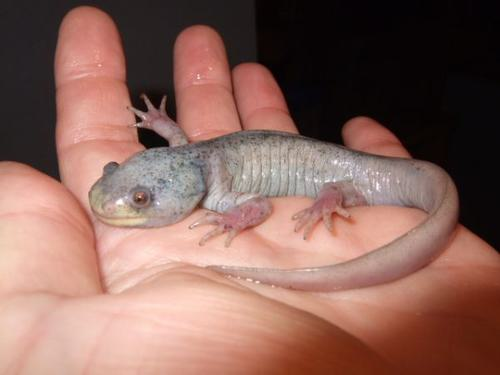
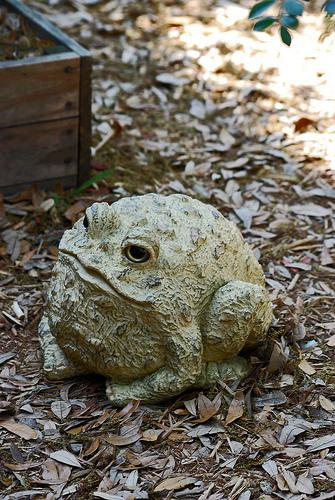
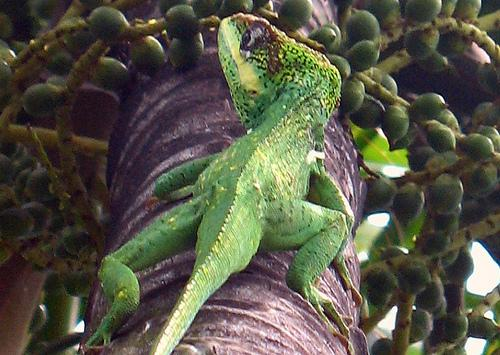
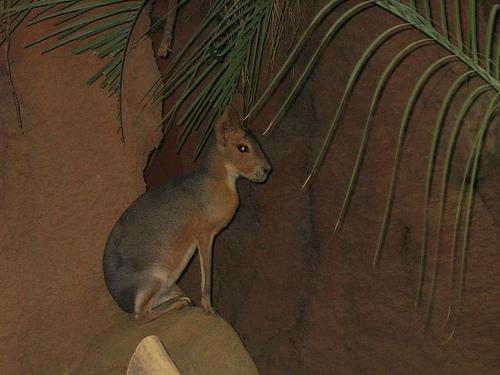
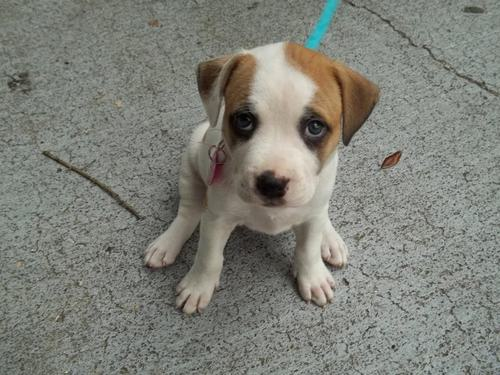
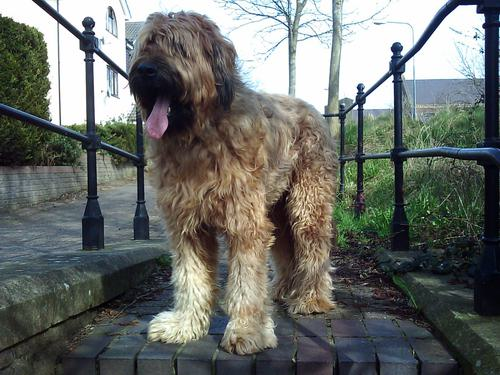
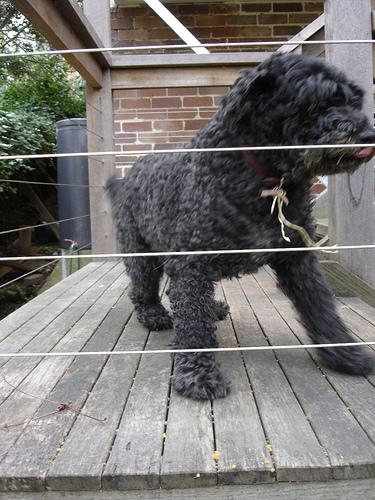
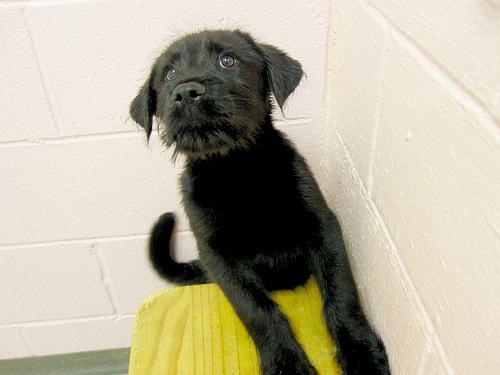
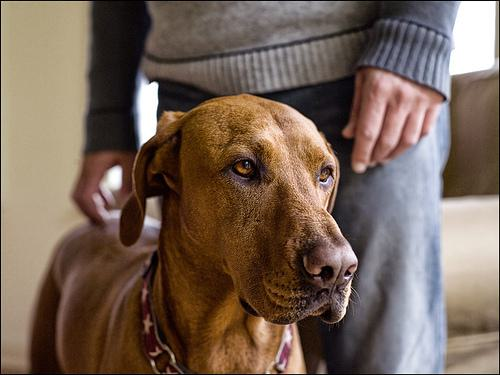
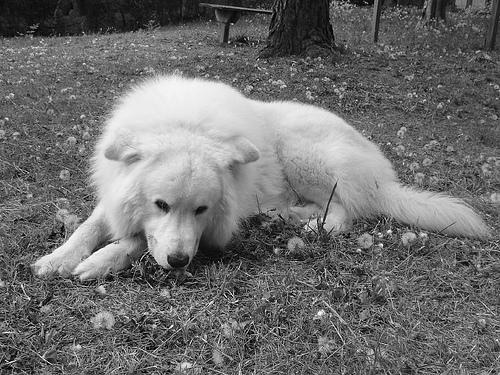
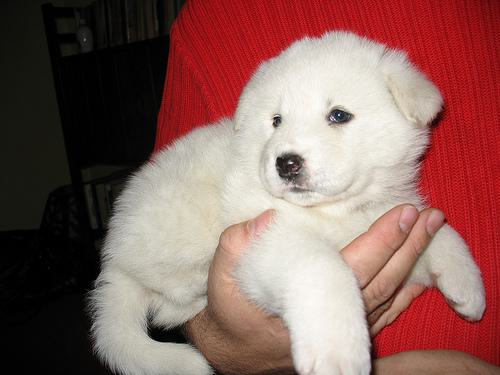
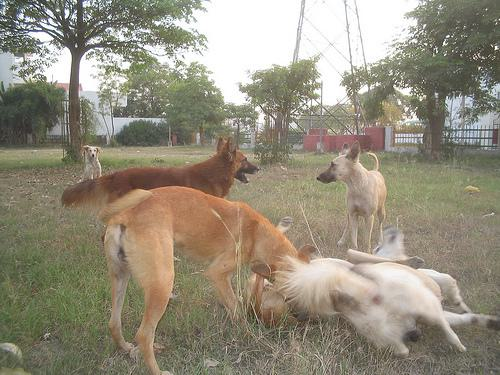
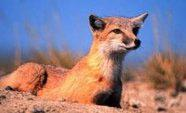
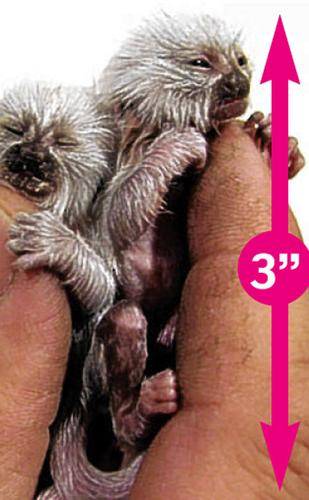
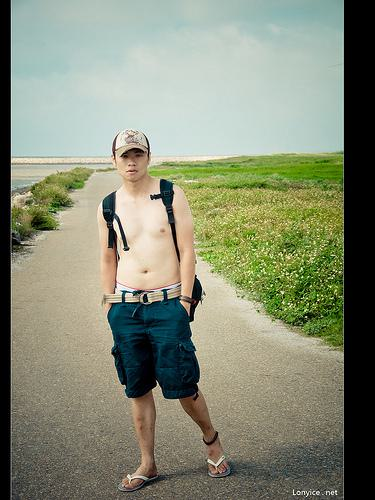
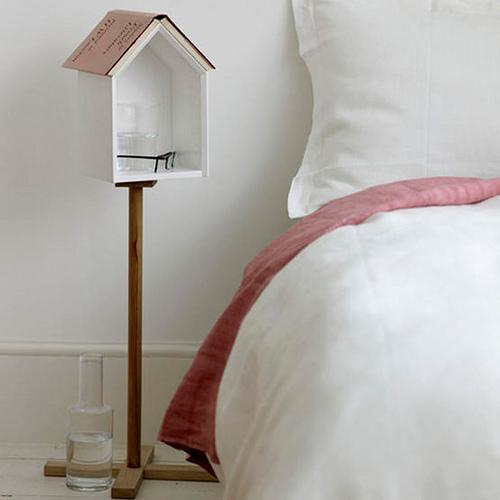
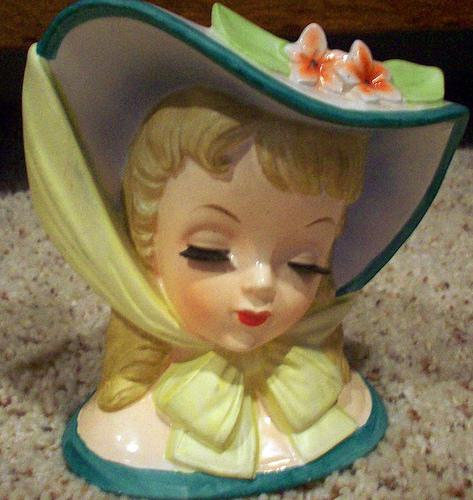
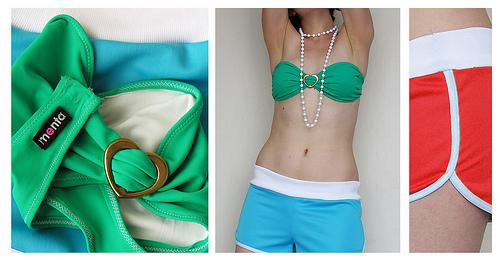
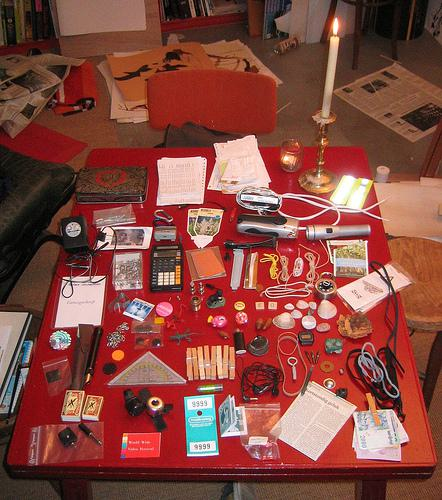
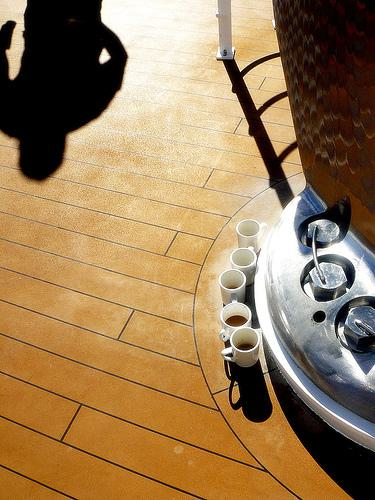
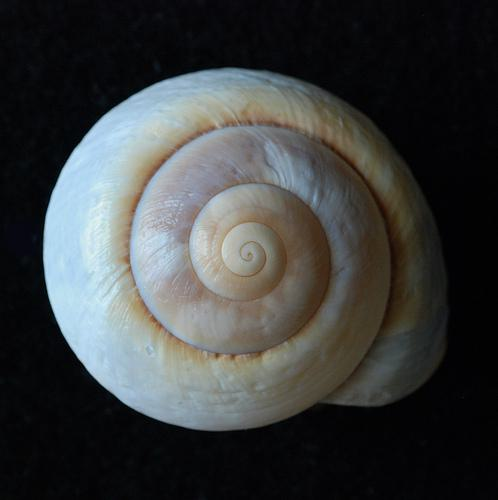
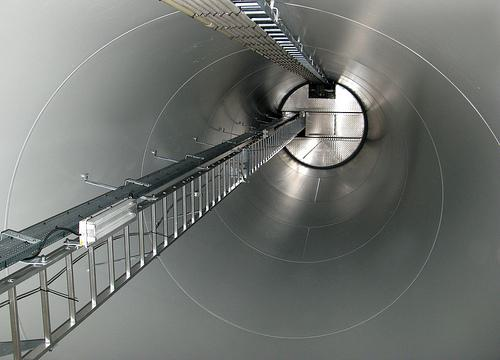
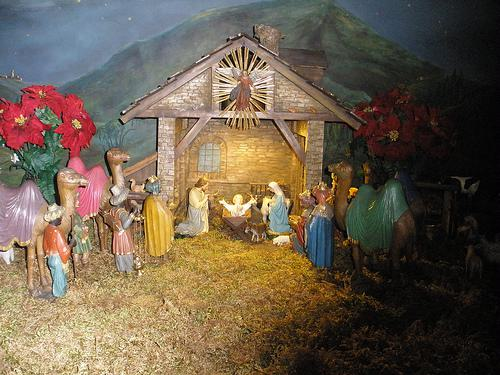
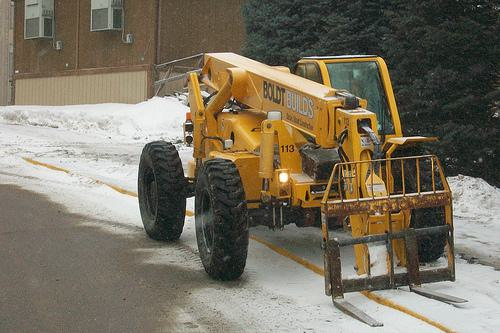
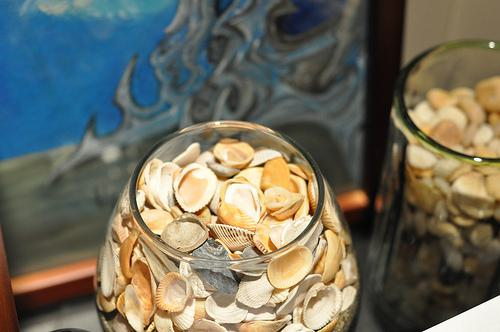
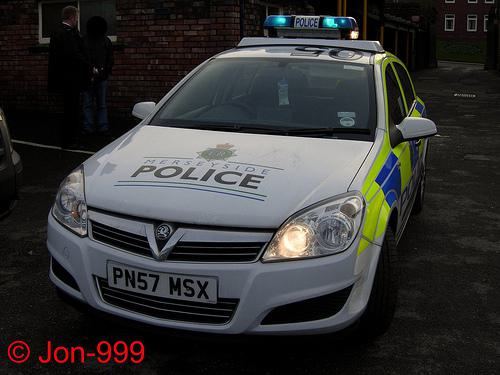
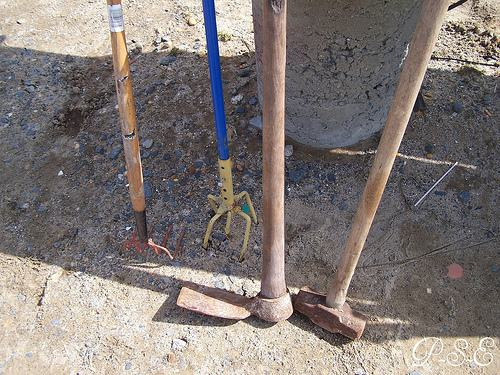
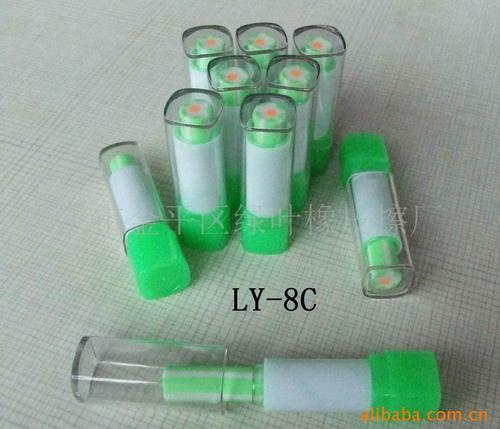
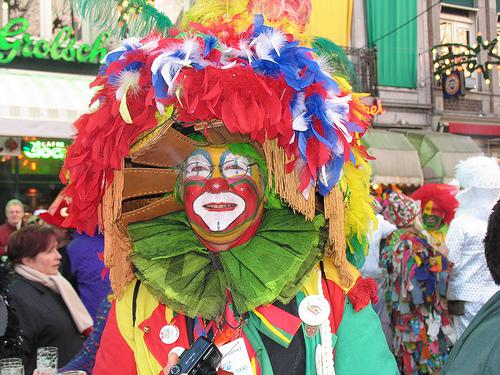
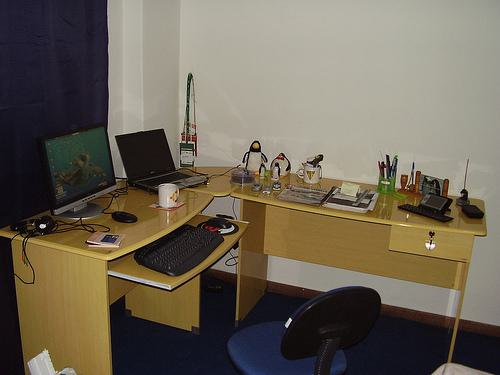
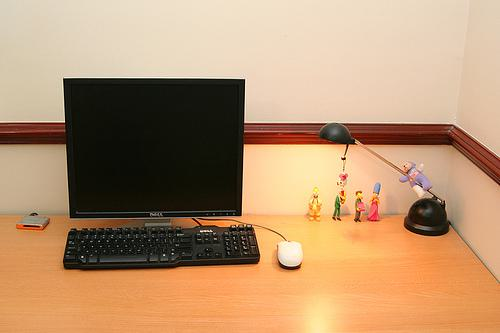
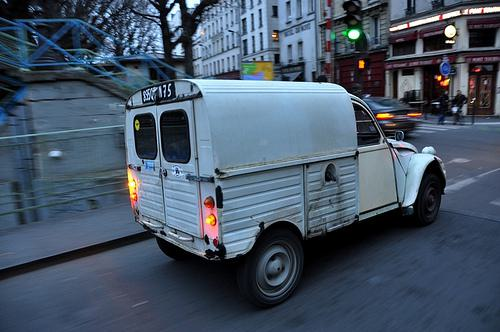
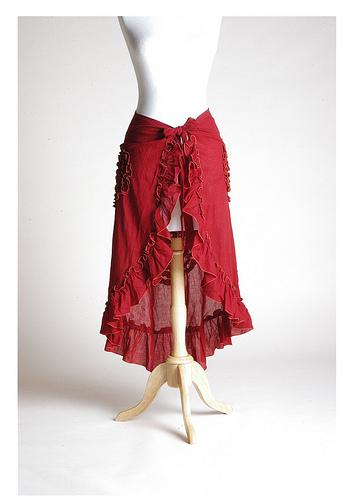
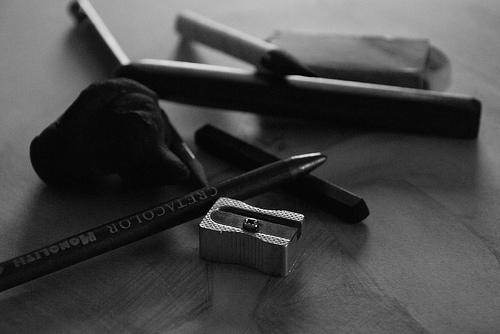
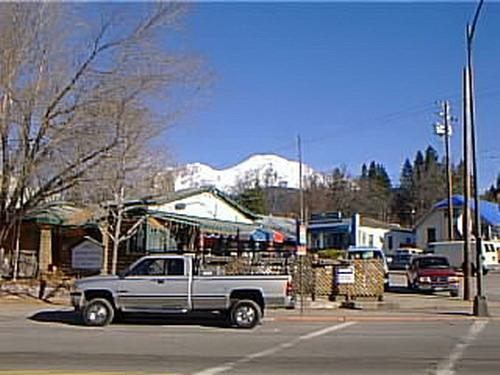
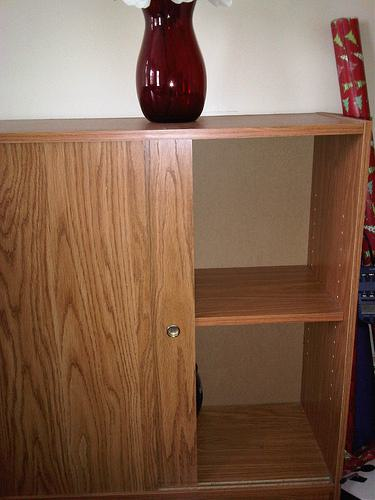
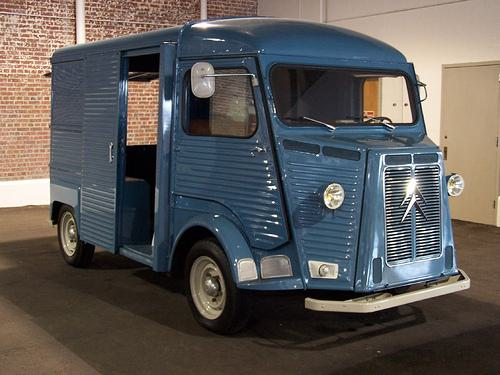
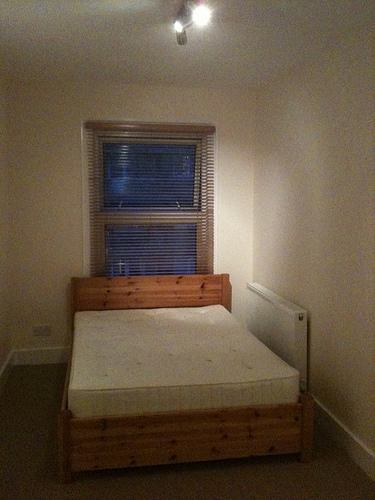
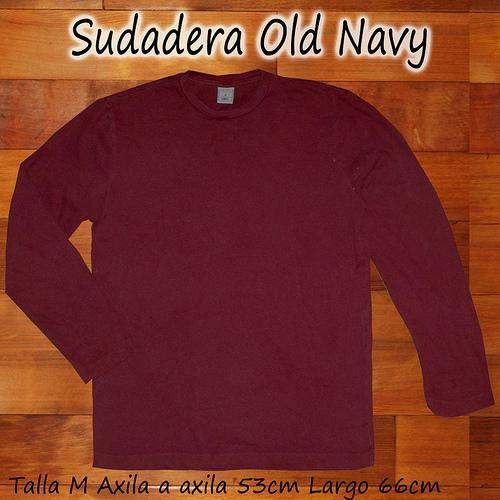
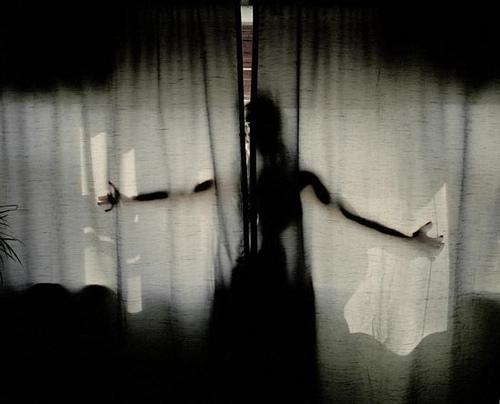
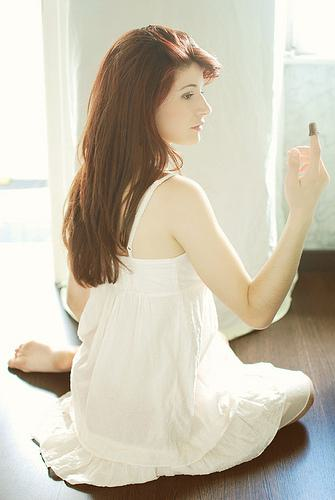
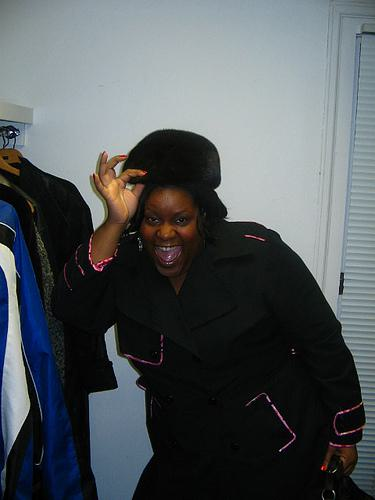
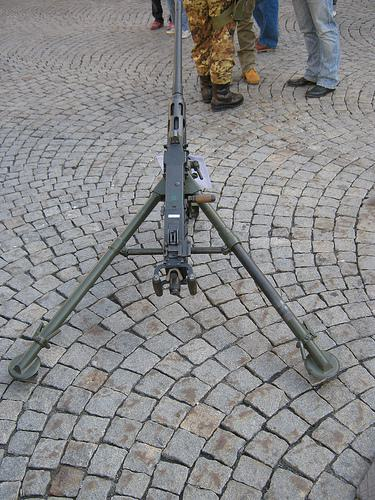
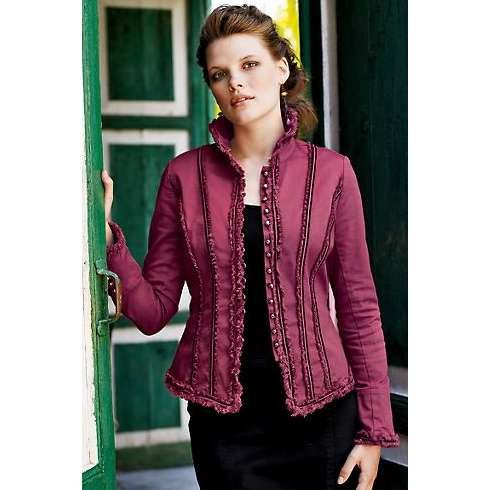
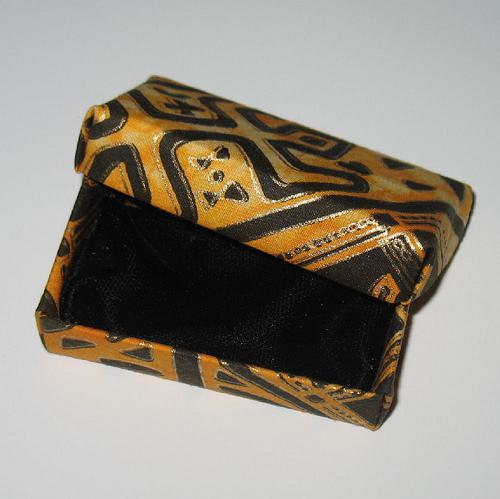
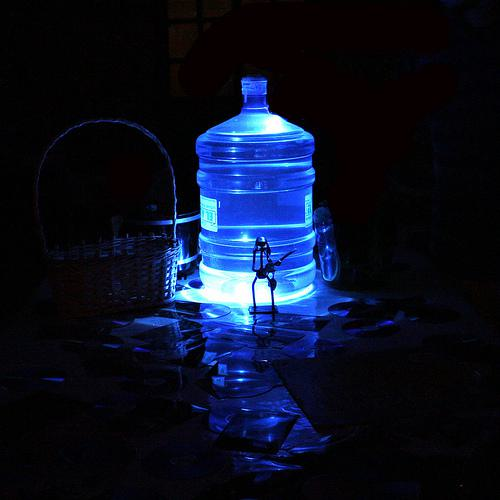
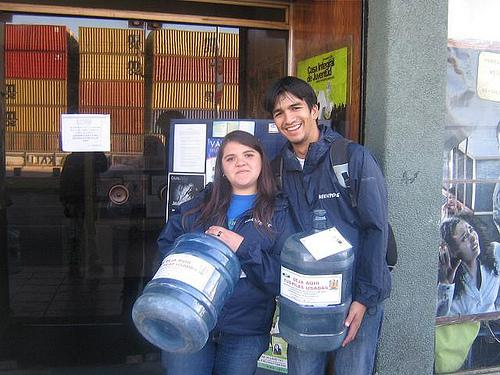
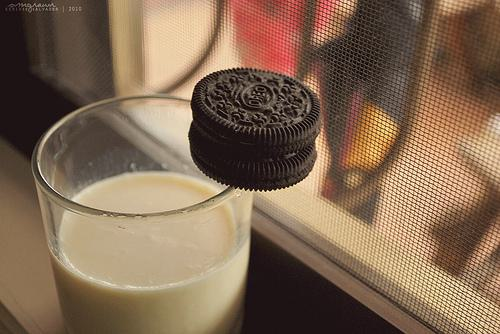
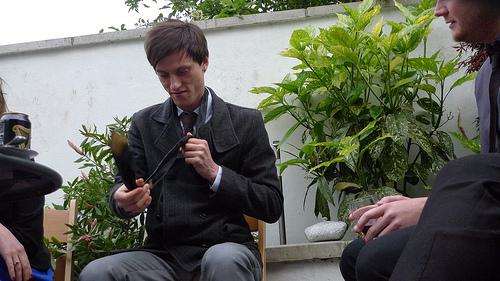
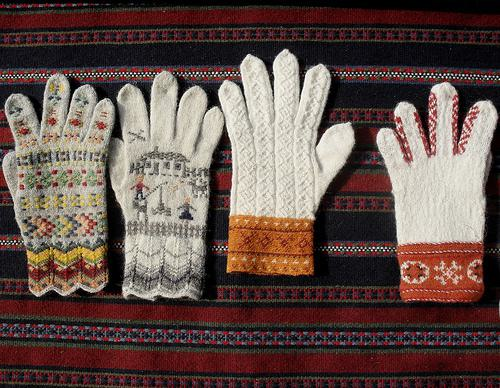
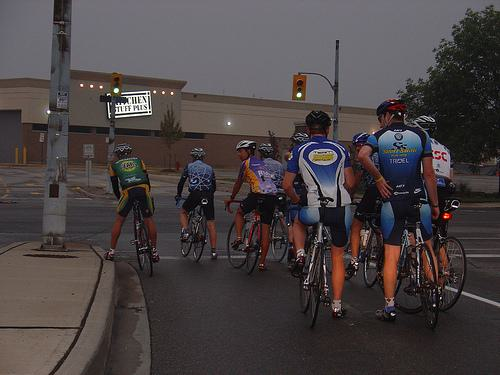
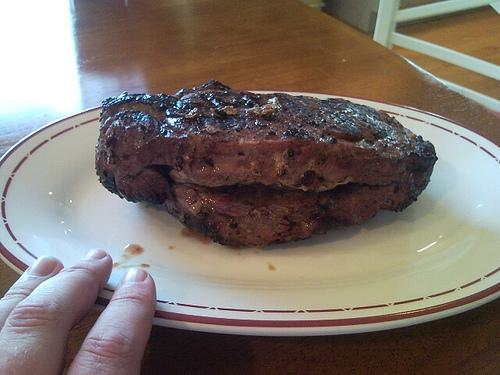
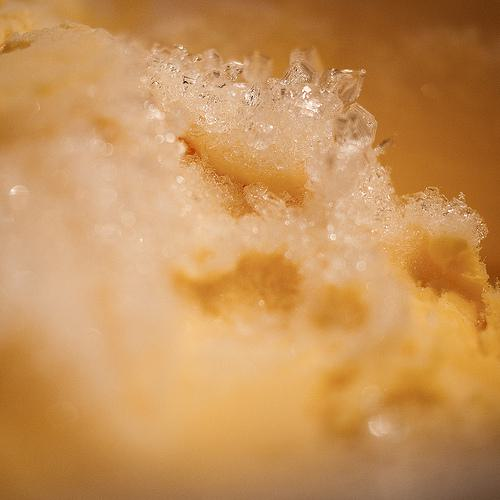
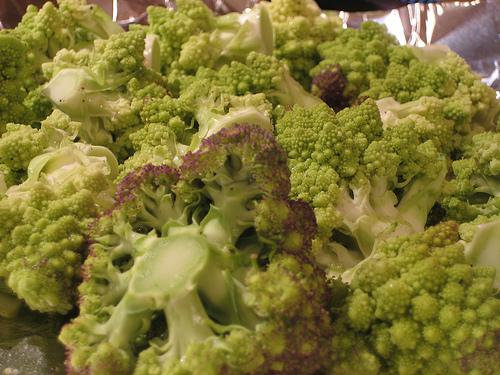
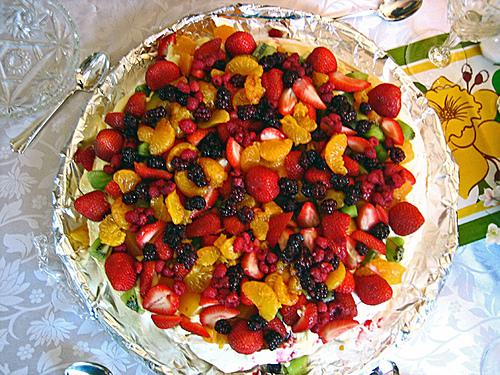
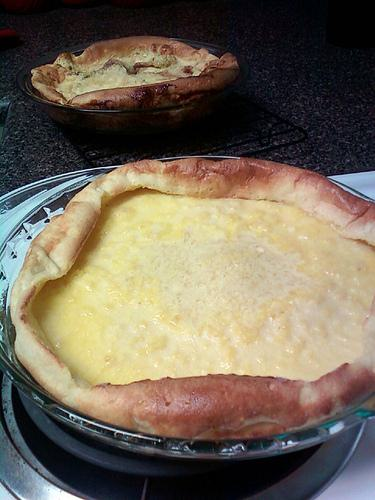
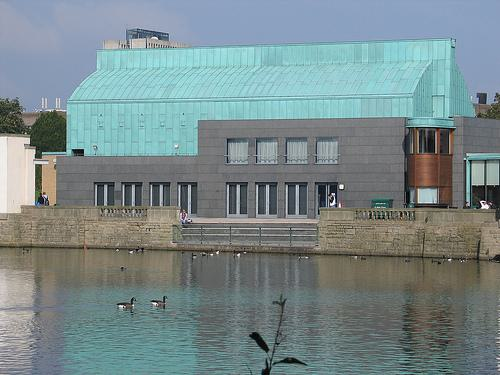

In [9]:
visualize_df(greedysoups_classified_not_matching)

# ====================

# Misc

In [10]:
# Filter samples where error classifications match:
df1 = get_mistakes_df('vit3b')
df1 = filter_mistakes(df1, classified_by_us=True, match_dough_bagel=True)

df2 = get_mistakes_df('greedysoups')
df2 = filter_mistakes(df2, classified_by_us=True, match_dough_bagel=True)

df_merged = pd.concat([df1, df2], ignore_index=True, sort=False)
assert df_merged.shape[0] == df1.shape[0] + df2.shape[0]

['Fine-grained error', 'Fine-grained error with OOV', 'Fine-grained with Multilabel Options', 'Non-prototypical', 'Spurious Correlation']


/tmp/ipykernel_1728621/3207358387.py:146: SettingWithCopyWarning:                                                                                     
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mistakes['DB_category'] = df_mistakes['file_name'].map(
/tmp/ipykernel_1728621/3207358387.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mistakes['DB_severity'] = df_mistakes['file_name'].map(


Model name: vit3b
All errors (Major + Minor) counts:
Number of mistakes: 378
                          DoughBagel same supercls (fine-gr)       fine-gr OOV (CLIP)                non-proto common co occ (spur corr)                    uncls              Total (row)
                  Fine-grained error                     191                       15                        0                       10                       25                      241
         Fine-grained error with OOV                       9                       20                        0                       11                       14                       54
Fine-grained with Multilabel Options                       1                        0                        0                        0                        0                        1
                    Non-prototypical                      13                        2                       12                        3                        0                  

Model name: greedysoups
All errors (Major + Minor) counts:
Number of mistakes: 249
                          DoughBagel same supercls (fine-gr)       fine-gr OOV (CLIP)                non-proto common co occ (spur corr)                    uncls              Total (row)
                  Fine-grained error                     139                       14                        1                        7                       11                      172
         Fine-grained error with OOV                       4                        7                        0                        4                        2                       17
               Fine-grained with OOV                       3                        1                        0                        1                        4                        9
                    Non-prototypical                       8                        1                        8                        2                        0            

/tmp/ipykernel_1728621/3207358387.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mistakes['DB_category'] = df_mistakes['file_name'].map(
/tmp/ipykernel_1728621/3207358387.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mistakes['DB_severity'] = df_mistakes['file_name'].map(


Number of samples: 28



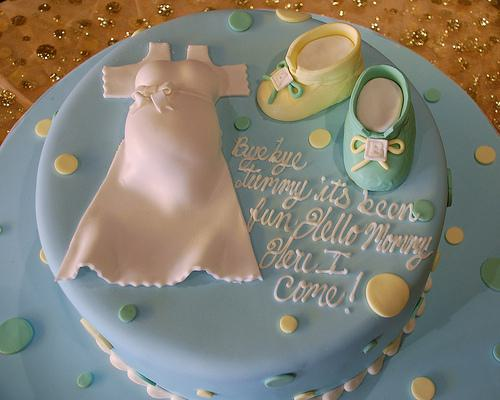
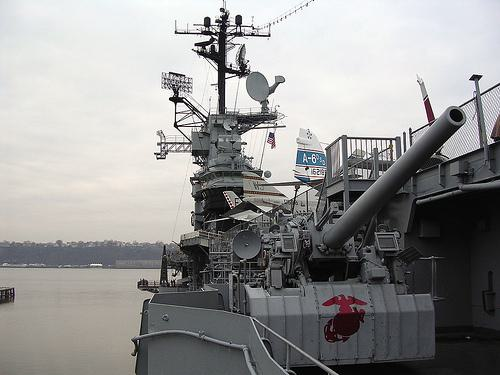
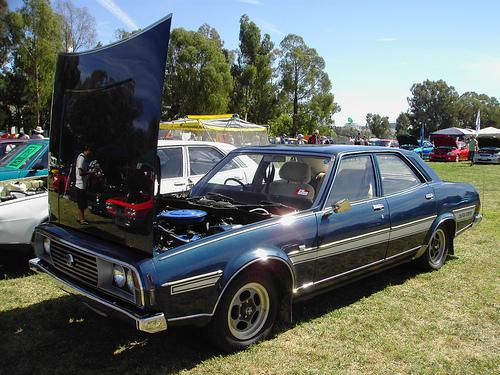
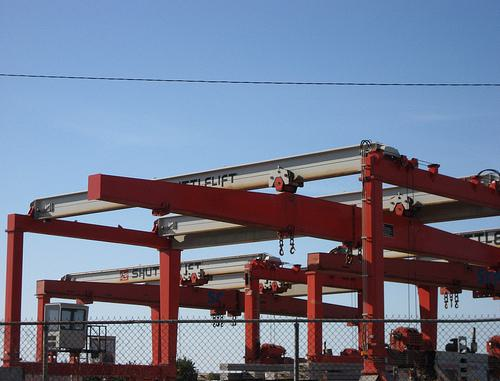
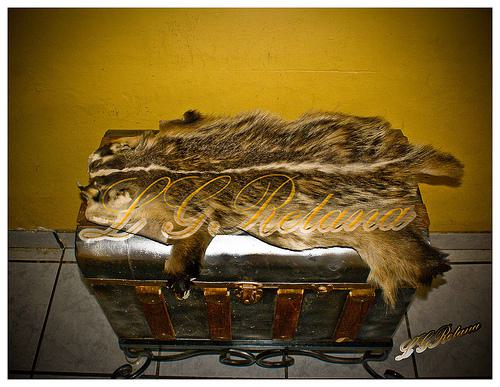
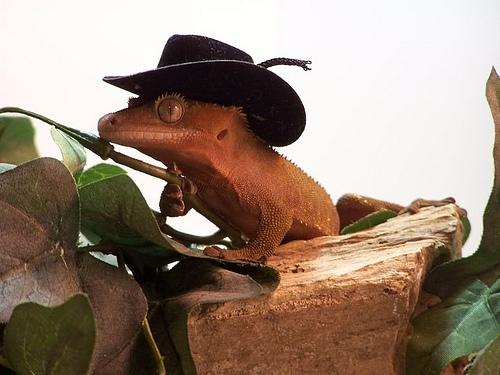
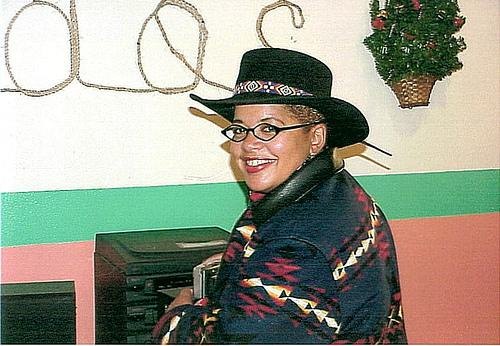
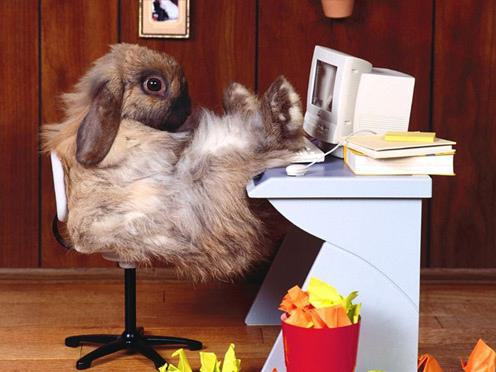
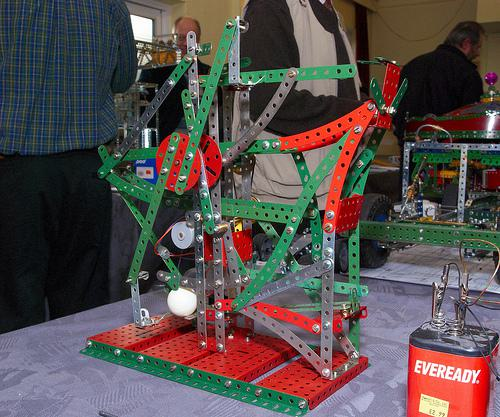
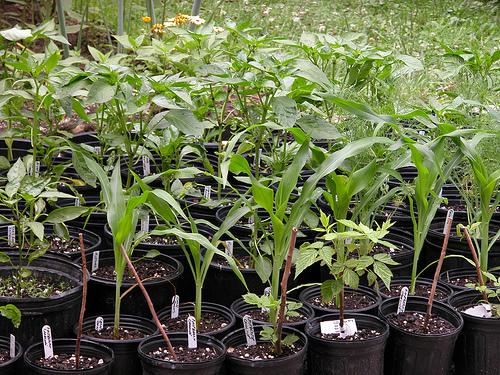
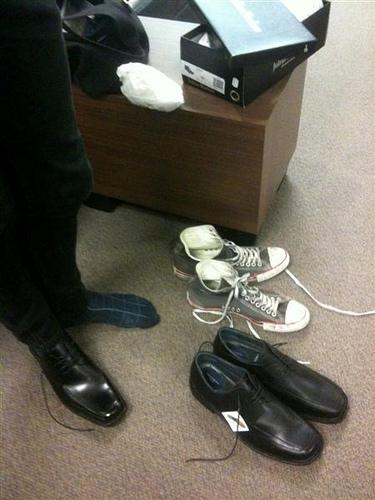
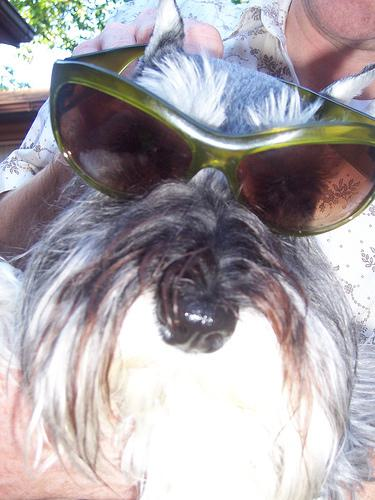
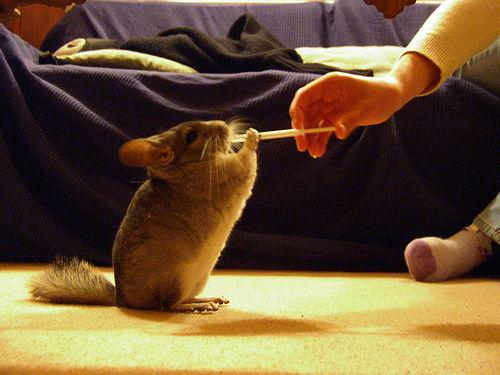
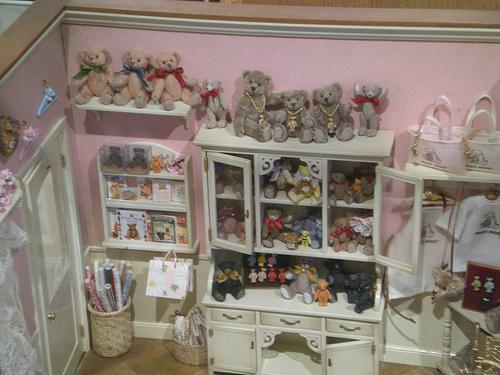
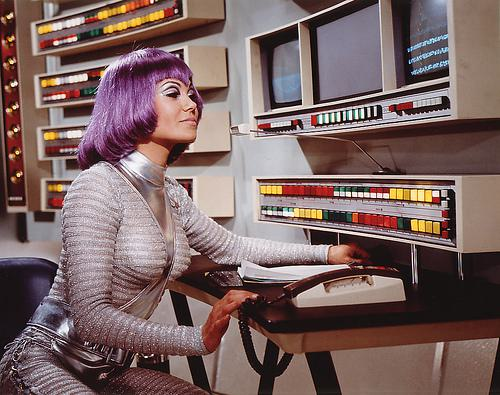
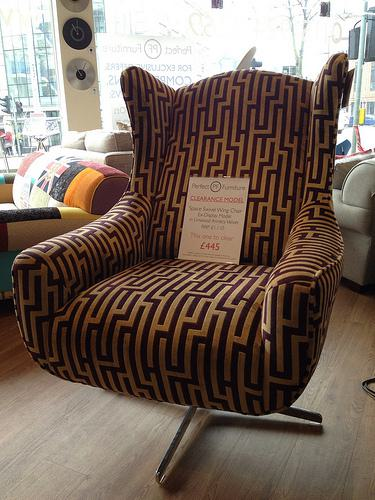
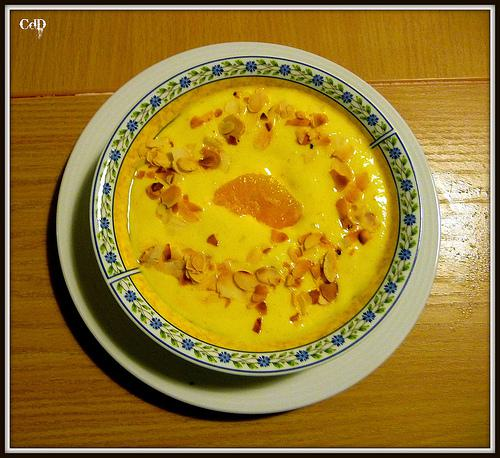
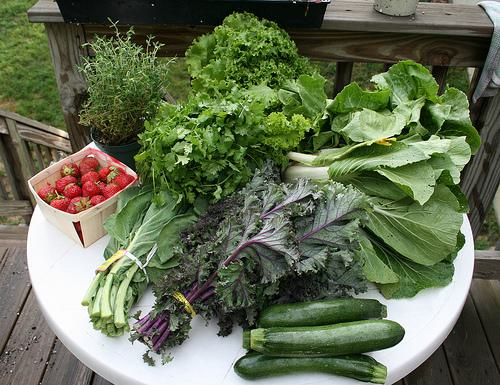
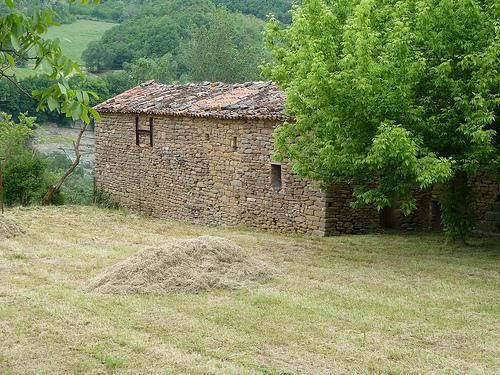
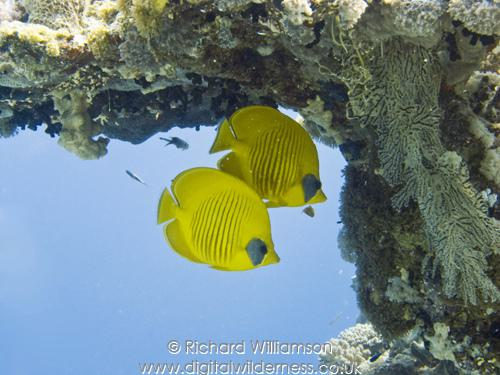
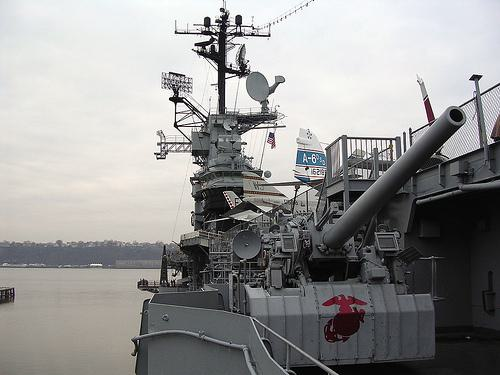
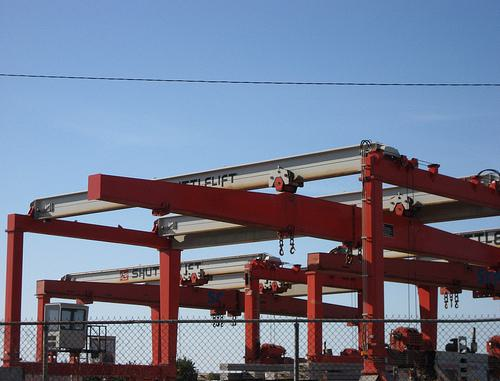
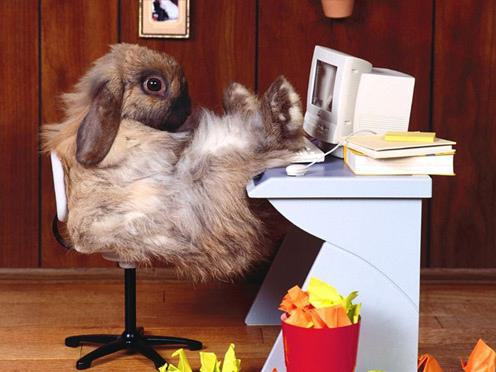
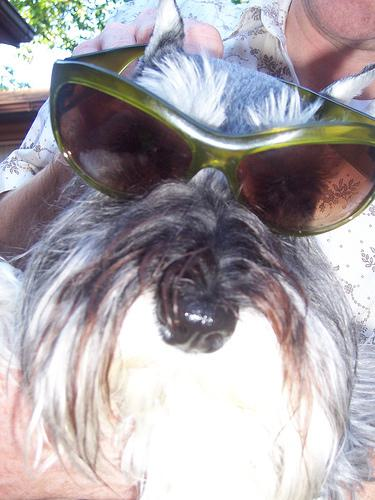
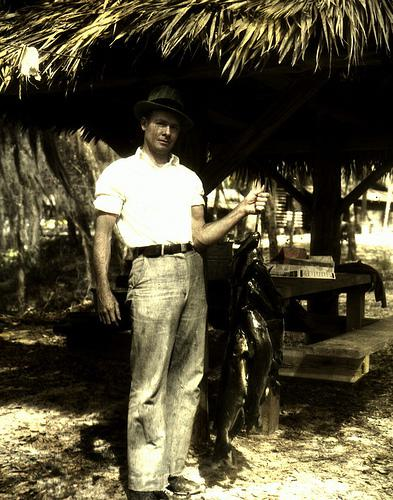
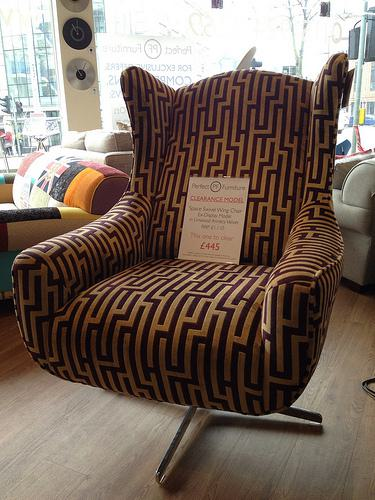
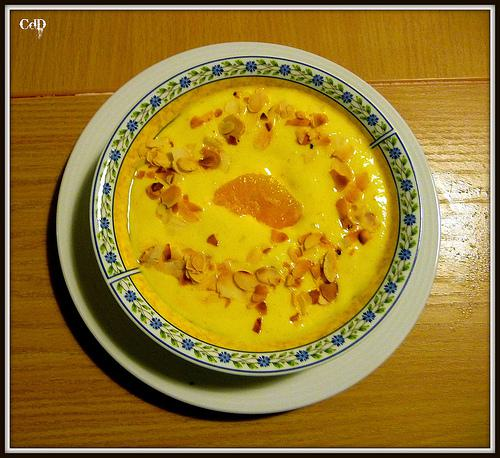
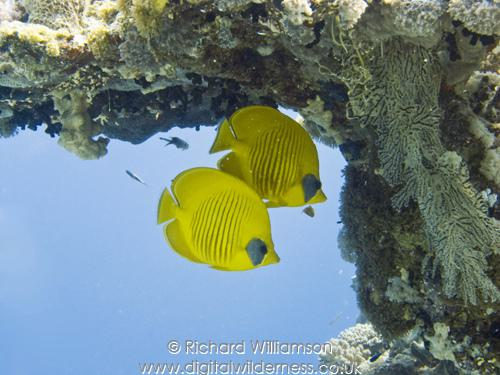

In [11]:
visualize_df(df_merged[ErrorClsTypes.filter_error_type(df_merged, ErrorClsTypes.OOV_detected_by_clip)])

In [12]:
eval_manager.debug_oov('ILSVRC2012_val_00008164.JPEG', df=df_merged)

Filtered: 2 rows, debugging only the first one

img_rel_path: n09256479/ILSVRC2012_val_00008164.JPEG
target: 973, multi_label: [973], multi_desc: ['(coral reef)']
top1: 392, top1_desc: rock beauty, Holocanthus tricolor
['potentially OOV, detected by CLIP', "Top-5 alternative proposals: [(2605316, 'butterfly fish', '70.75%'), (2605936, 'angelfish', '23.69%'), (2605703, 'chaetodon', '3.75%'), (1443537, 'carassius auratus', '0.43%'), (2552171, 'spiny-finned fish', '0.27%')] | out of 52"]

clip_top10_train_files:
n02606052/n02606052_22953.JPEG
n02606052/n02606052_448.JPEG
n02606052/n02606052_20464.JPEG
n02606052/n02606052_22729.JPEG
n02606052/n02606052_12701.JPEG
n02606052/n02606052_1622.JPEG
n02606052/n02606052_1630.JPEG
n02606052/n02606052_5444.JPEG
n02606052/n02606052_5931.JPEG
n02606052/n02606052_5016.JPEG

clip_top10_supercls: ['fish_rest', 'fish_rest', 'fish_rest', 'fish_rest', 'fish_rest', 'fish_rest', 'fish_rest', 'fish_rest', 'fish_rest', 'fish_rest']
top-1 prediction superclasses

In [13]:
vit3b_df = eval_manager.prepare_and_eval_model('vit3b')
vit3b_df = vit3b_df[~vit3b_df['is_problematic']]
vit3b_df = vit3b_df[~ErrorClsTypes.filter_error_type(vit3b_df, ErrorClsTypes.correct)]
# Sort by number of multi labels:
vit3b_df['num_labels'] = vit3b_df['multi_label'].map(lambda multi_label: len(multi_label))
vit3b_df = vit3b_df.sort_values(by=['num_labels'], ascending=False)

Number of samples: 20



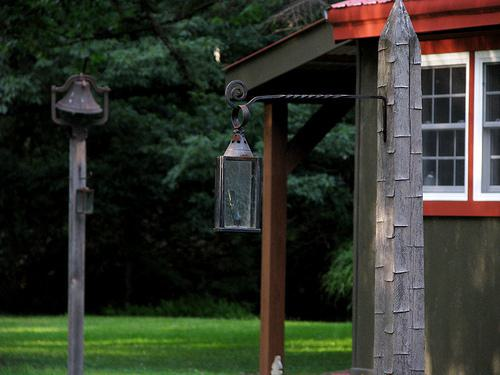
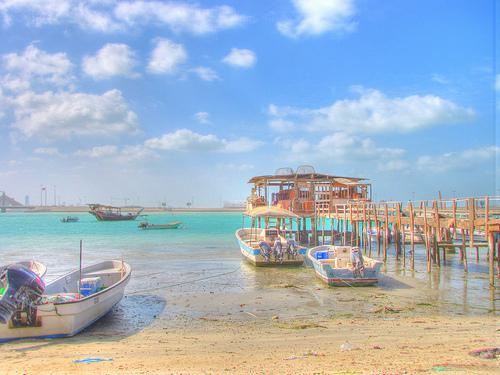
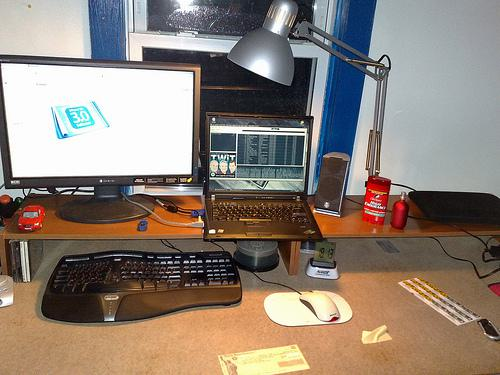
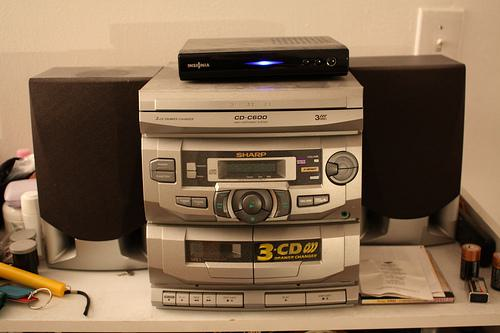
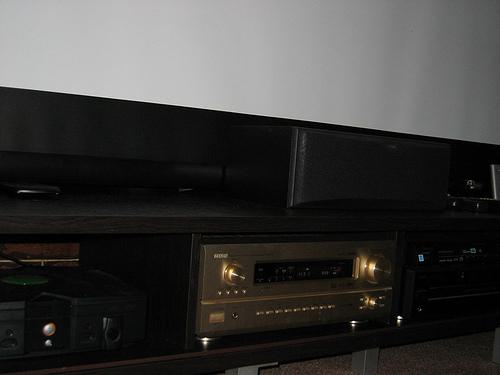
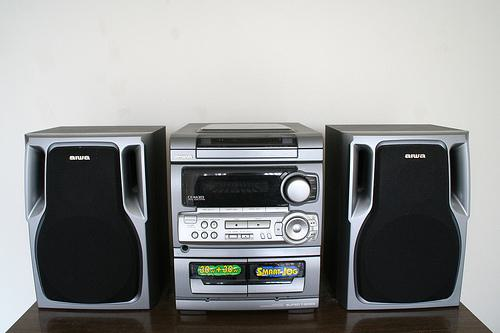
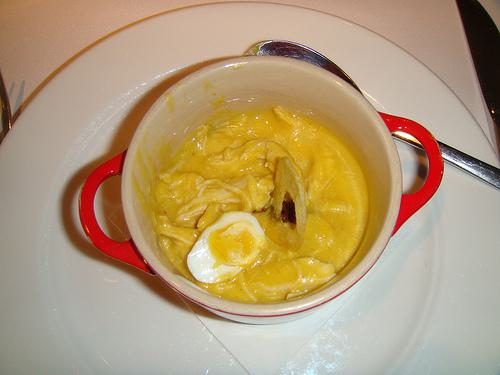
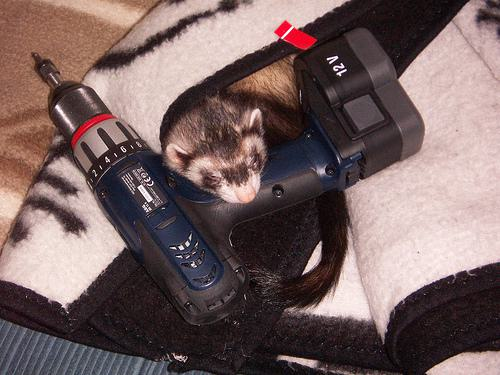
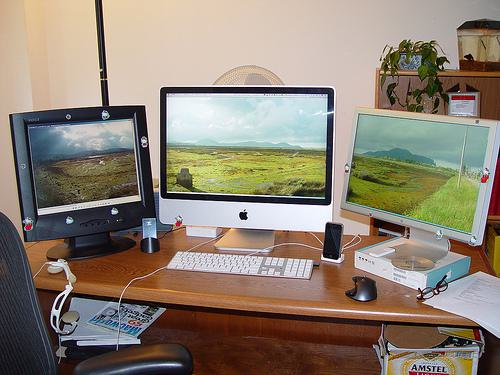
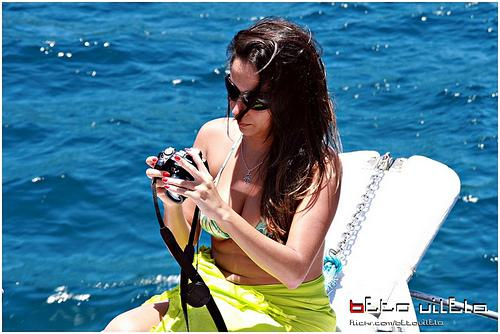
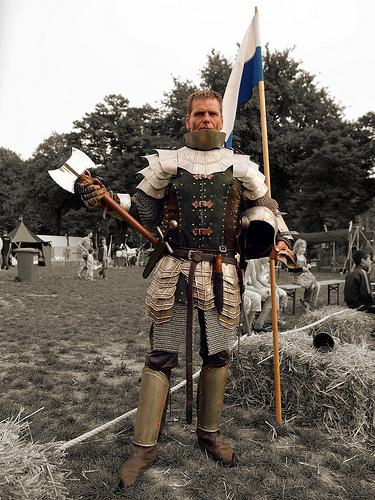
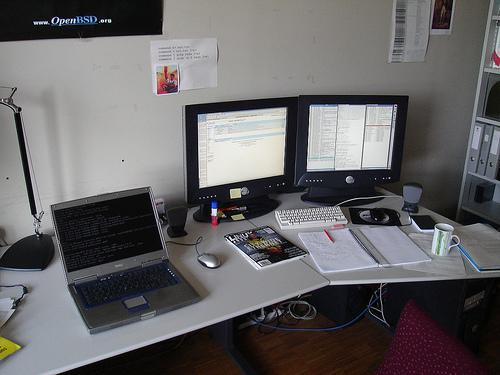
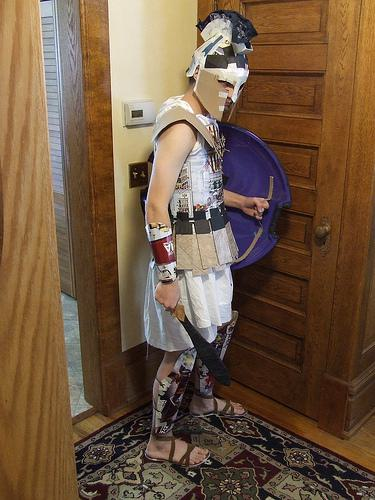
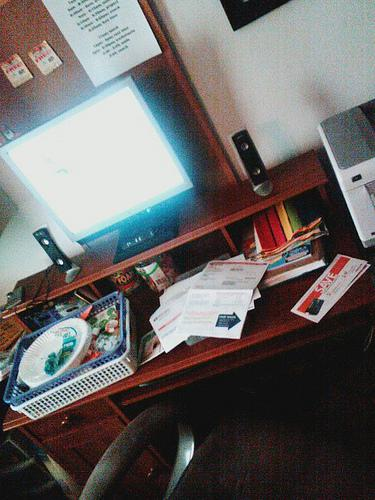
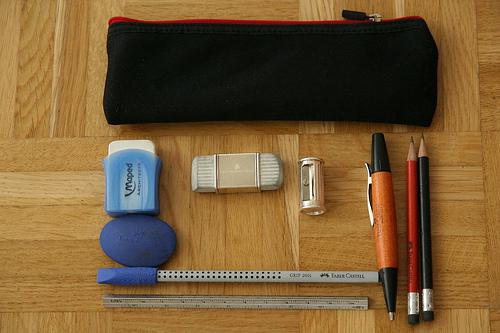
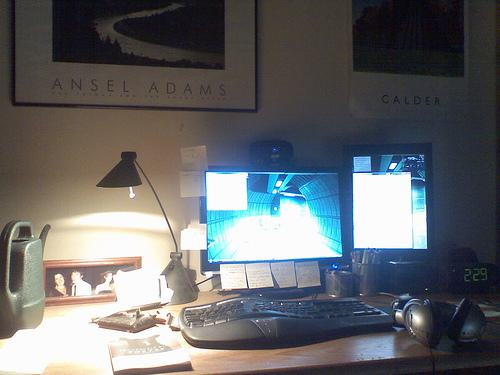
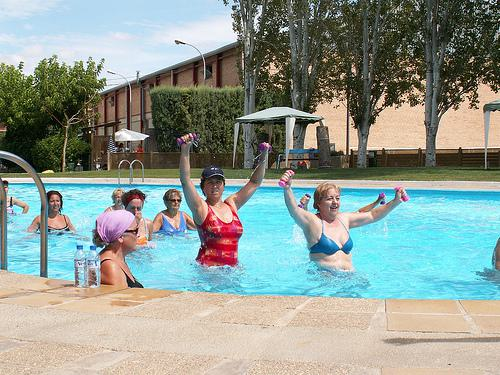
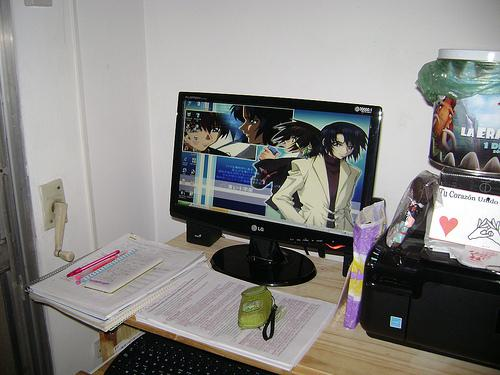
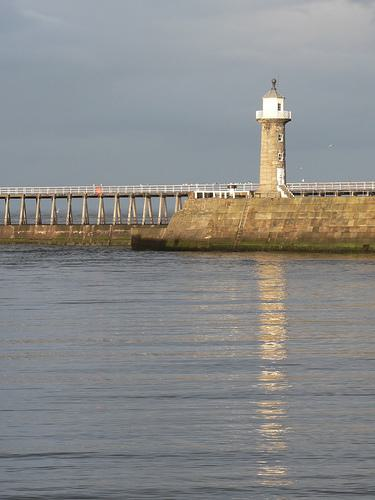
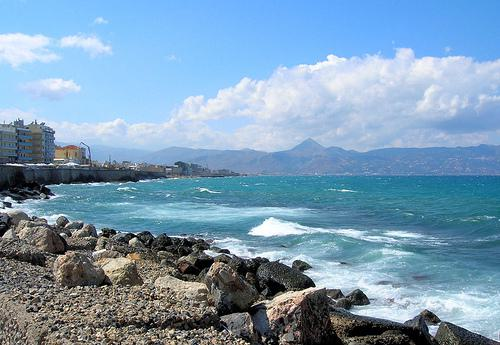

In [14]:
visualize_df(vit3b_df[ErrorClsTypes.filter_error_type(vit3b_df, ErrorClsTypes.correct_multi_label)][20:40])